 # <center> Transport in Ireland * Road Safety
***

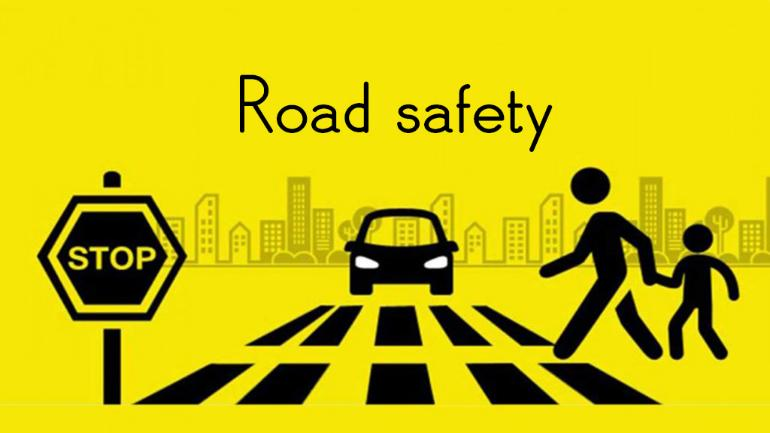

Name: **Natalia Iolchin**

Student No: **sba23303**

Assignment: **MSc_DA_CA2**
***

<a class="anchor" id="0.1"></a>
# Table of Contents

### [0. Introduction](#0)
* [**0.1 Data Mining Framework**](#0.0.1)
* [**0.2 Notebook Settings/Requirements**](#0.0.2)

### [1. Transportation safety overview](#1)
* [**1.1 Transportation safety in Europe**](#1.1)
* [**1.2 Transportation safety in Ireland**](#1.2)
    * [1.2.1 Data Selection](#1.2.1)
    * [1.2.2. Data Preprocessing](#1.2.2)
    * [1.2.3 Data Transformation](#1.2.3)
    * [1.2.4 Data Exploration](#1.2.4)

### [2. Ireland road safety analysis using time series](#2)
* [**2.1 Data upload & processing**](#2.1)
* [**2.2 Data Exploration**](#2.2)
* [**2.3 Forecasting a time series**](#2.3)
    * [2.3.1 Augmented Dickey–Fuller test](#2.3.1)
    * [2.3.2 Finding parameters for the ARIMA model](#2.3.2)
* [**2.4 Building Auto Arima Forecasting**](#2.4)
    * [2.4.1 Plot diagnostics](#2.4.1)
    * [2.4.2 Interpretation of plots](#2.4.2)
    * [2.4.3 Forecast](#2.4.3)
* [**2.5 Machine learning modeling**](#2.5)
    * [2.5.1 Splitting and reshaping the data](#2.5.1)
    * [2.5.2 Creating a function to evaluate and plot a regressor](#2.5.2)
    * [2.5.3 Random Forest](#2.5.3)
    * [2.5.4 Linear Regression](#2.5.4)
    * [2.5.5 Ridge](#2.5.5)
    * [2.5.6 Lags on time series](#2.5.6)
        * [2.5.6.1 Decision tree](#2.5.6.1)
        * [2.5.6.2 Random Forest](#2.5.6.2)
        * [2.5.6.3 Gradient Boosted Tree](#2.5.6.3)
        



### [3. Ireland road safety in comparison with other countries](#3)
* [**3.1 Choice of countries**](#3.1)
    * [3.1.1 Populatopn Density comparison](#3.1.1)
    * [3.1.2 Transport Accessibility comparison](#3.1.2)
    * [3.1.3 Road Safety comparison](#3.1.3)
    * [3.1.4 Selecting TOP-5 countries](#3.1.4)
    * [3.1.5 Making final decision based on data visualisation](#3.1.5)
* [**3.2 Data collection, preprocessing, exploring and transformation**](#3.2)
    * [3.2.1 IRELAND - data preparation](#3.2.1)
    * [3.2.2 Norway - data preparation](#3.2.2)
    * [3.2.3 Denmark - data preparation](#3.2.3)
* [**3.3 Comparison of countries**](#3.3)
    * [3.3.1 Collisions Number comparisson](#3.3.1)
    * [3.3.2 Casualties Number comparisson](#3.3.2)

### [4. Ireland 'Road Safety' sentiment analysis](#4)

* [**4.1. Sentimental Analysis for Reddit comments**](#4.1)
    * [4.1.1 Data collection](#4.1.1)
    * [4.1.2 Data preparation](#4.1.2)
    * [4.1.3 Mapping the compound scores](#4.1.3)
    * [4.1.4 Displaying result of sentiment analysis](#4.1.4)
* [**4.2 Bag of Words Vectorization**](#4.2)
* [**4.3 Word Cloud**](#4.3)

<a class="anchor" id="0"></a>
## 0. Introduction
[Back to Table of Contents](#0.1)

<a class="anchor" id="0.0.1"></a>
## 0.1. Data Mining Framework
[Back to Table of Contents](#0.1)

Each part of this work follows same framework that contain a mix of KDD and SEMMA data mining process. Some parts of the work may combine 2 or more phases or have phase that is more granulated.  

Following steps in terms of data: 
* Selection
* Preprocessing
* Transformation
* Exploration
* Modification
* Modeling
* Assessing/Interpretation/Evaluation

<a class="anchor" id="0.0.2"></a>
## 0.2. Notebook Settings/Requirements
[Back to Table of Contents](#0.1)

In [ ]:
!pip freeze > requirements.txt

**Used Python 3 environment comes with many helpful analytics libraries installed**

In [2]:
# Importing necessary libraries

# data loading and manipulation
import pandas as pd # dataframe manipulation
import numpy as np # linear algebra
import math #for math operations
from pyjstat import pyjstat #JSON reading
import praw #access Reddit's data
import os #interact with the operating system
from collections import Counter
from io import BytesIO # work with in-memory binary data
import requests # send HTTP requests

# Visualization
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.figure import Figure
import hvplot.pandas
import panel as pn
import plotly.express as px
from wordcloud import WordCloud
from PIL import Image
%matplotlib inline

#statistic libraries
from scipy import stats
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from numpy import log
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
from sklearn.metrics import mean_absolute_error, mean_squared_error
import statistics as stats
import scipy as scipy
import pmdarima as pm
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy as scipy

# language processing 
import nltk
from nltk.stem import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download("vader_lexicon")
import string
import re

# machine learning 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

import warnings # Supress warnings 
warnings.filterwarnings('ignore')

<a class="anchor" id="1"></a>
# 1. Transportation safety overview
[Back to Table of Contents](#0.1)

<a class="anchor" id="1.1"></a>
## 1.1.Transportation safety in Europe
[Back to Table of Contents](#0.1)

In [3]:
df_avia = pd.read_csv('tran_sf_aviaca_linear.csv')
df_rail = pd.read_csv('tran_sf_railvi_linear.csv')
df_mar = pd.read_csv('tran_sf_marv_linear.csv')
df_road = pd.read_csv('tran_sf_roadse_linear.csv')

In [4]:
avia_value = df_avia[(df_avia['TIME_PERIOD'] == 2021) & 
                      (df_avia['geo'] == 'EU27_2020') & 
                      (df_avia['victim'] == 'KIL')]['OBS_VALUE'].sum()
rail_value = df_rail[(df_rail['TIME_PERIOD'] == 2021) & 
                      (df_rail['geo'] == 'EU27_2020') & 
                      (df_rail['victim'] == 'KIL')]['OBS_VALUE'].sum()
mar_value = df_mar[(df_mar['TIME_PERIOD'] == 2021) & 
                      (df_mar['c_regis'] == 'EU27_2020') & 
                      (df_mar['victim'] == 'KIL')]['OBS_VALUE'].sum()
road_value = df_road[(df_road['TIME_PERIOD'] == 2021) & 
                      (df_road['geo'] == 'EU27_2020')]['OBS_VALUE'].sum()

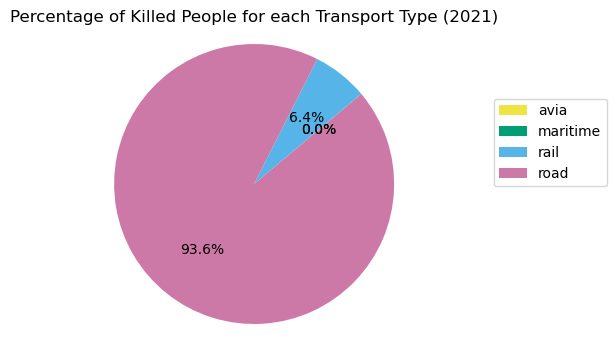

In [5]:
df_kil = pd.DataFrame({'transport_type': ['avia','maritime','rail','road'],
                       'Killed Number': [avia_value, mar_value, rail_value, road_value]})

# Define a custom color palette
custom_colors = ['#F0E442', '#009E73', '#56B4E9','#CC79A7']

# Plotting a pie chart with a custom color palette
plt.figure(figsize=(6, 4))
plt.pie(df_kil['Killed Number'], labels=None, autopct='%1.1f%%', startangle=40, colors=custom_colors)
plt.title('Percentage of Killed People for each Transport Type (2021)')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

# Displaying only the legend outside the pie chart
plt.legend(df_kil['transport_type'], bbox_to_anchor=(1, 0.8), loc="upper left")
plt.show()

In [6]:
rail_ie = df_rail[(df_rail['TIME_PERIOD'] == 2021) & 
                      (df_rail['geo'] == 'IE') & 
                      (df_rail['victim'] == 'KIL')]['OBS_VALUE'].sum()
road_ie = df_road[(df_road['TIME_PERIOD'] == 2021) & 
                      (df_road['geo'] == 'IE')]['OBS_VALUE'].sum()

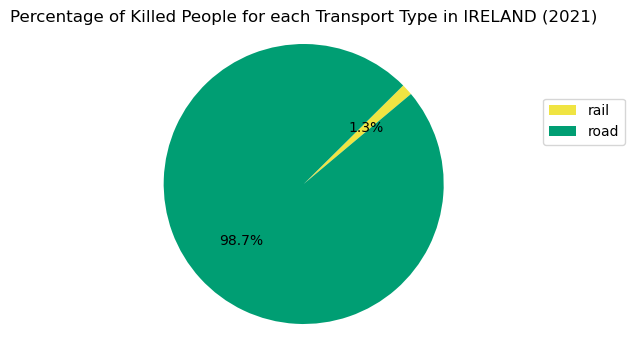

In [7]:
df_ie = pd.DataFrame({'transport_type': ['rail','road'],
                       'Killed Number': [ rail_ie, road_ie]})

# Define a custom color palette
custom_colors = ['#F0E442', '#009E73', '#56B4E9','#CC79A7']

# Plotting a pie chart with a custom color palette
plt.figure(figsize=(6, 4))
plt.pie(df_ie['Killed Number'], labels=None, autopct='%1.1f%%', startangle=40, colors=custom_colors)
plt.title('Percentage of Killed People for each Transport Type in IRELAND (2021)')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

# Displaying only the legend outside the pie chart
plt.legend(df_ie['transport_type'], bbox_to_anchor=(1, 0.8), loc="upper left")
plt.show()

<a class="anchor" id="1.2"></a>
## 1.2. Transportation safety in Ireland
[Back to Table of Contents](#0.1)


This section will analize road safety during period of time from 2005 - 2021 in monthly slice.

Focus will be on number of total collisions as the main and the most important indicator of safety.

Methods used:
- For the data collection: JSON.stat downloaded via API from CSO website.
- For the data processing: isna(), reset_index(), fillna.mean(), to_datetime(),groupby.unstack()


<a class="anchor" id="1.2.1"></a>
### 1.2.1. Data Selection

[Back to Table of Contents](#0.1)

CSO website is providing data in different formats. JSON.stat is the common one that will be used for current analysis.

Following official CSO documentation is used to download a JSON file via API.

https://github.com/CSOIreland/PxStat/wiki/API-Cube-PxAPIv1

In [8]:
#downloading the data in JSON.stat

by_month = 'https://ws.cso.ie/public/api.restful/PxStat.Data.Cube_API.PxAPIv1/en/46/RSARS/ROA17?query=%7B%22query%22:%5B%5D,%22response%22:%7B%22format%22:%22json-stat2%22,%22pivot%22:null,%22codes%22:false%7D%7D'


JSON represents objects as name/value pairs, just like a Python dictionary. The JSON-stat format is a simple lightweight JSON format for data dissemination. 
pyjstat is a python library for JSON-stat formatted data, which allows reading and writing JSON-stat easily.

https://pypi.org/project/pyjstat/ 

In [9]:
#installing pyjstat
#!pip install pyjstat

<a class="anchor" id="1.2.2"></a>
### 1.2.2. Data Preprocessing
[Back to Table of Contents](#0.1)

In [10]:
#Parsing JSON to dataset
dataset = pyjstat.Dataset.read(by_month)

In [11]:
# Creating pandas data frame from available dataset
df_ie = dataset.write('dataframe')
df_ie.head()

,Statistic,Year,Month of Year,value
0,Fatal Collisions,2005,All months,360.0
1,Fatal Collisions,2005,January,31.0
2,Fatal Collisions,2005,February,34.0
3,Fatal Collisions,2005,March,23.0
4,Fatal Collisions,2005,April,20.0


<a class="anchor" id="1.2.3"></a>
### 1.2.3 Data Transformation
[Back to Table of Contents](#0.1)


**Note**

At first glance it seen that there is "All months" value in the list of months. In order to keep omogenity of the data this value needs to be dropped.

In [12]:
df_ie = df_ie.drop(df_ie[(df_ie['Month of Year'] == 'All months')].index) #impact omogenity of the data
df_ie = df_ie.reset_index(drop=True)

In [13]:
#Checking data types and null values
df_ie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1224 entries, 0 to 1223
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Statistic      1224 non-null   object 
 1   Year           1224 non-null   object 
 2   Month of Year  1224 non-null   object 
 3   value          1223 non-null   float64
dtypes: float64(1), object(3)
memory usage: 38.4+ KB


**Note** 

Dataframe has 3 categorical fields: 'Year','Month of Year', 'Statistic' and 1 numerical with 1 missing value. Let's inspect them 1 by 1.

**Missing value handling**

In [14]:
# There is 1 null value. let's examine it and decide how to handle it
row_with_na = df_ie[df_ie.isna().any(axis=1)]
row_with_na

,Statistic,Year,Month of Year,value
1211,All Killed and Injured Casualties,2020,December,NaN


**Note**
Missing value is from the focus indicator, so it's better to have it filled. Let's explore the data deeper and check <b>mean</b> and <b> std </b> for casualties:
    
- for the available time period 
- for December from all years
- for 2020


In [15]:
# filtering fot available time period
filtered_df = df_ie[(df_ie['Statistic'] == 'All Killed and Injured Casualties')]
filtered_df.describe()

,value
count,203.000000
mean,676.354680
std,123.936235
min,166.000000
25%,612.000000
50%,680.000000
75%,743.500000
max,995.000000


In [16]:
#filtering for December
filtered_df = df_ie[(df_ie['Statistic'] == 'All Killed and Injured Casualties') & 
                  (df_ie['Month of Year'] == 'December') ]
filtered_df.describe()

,value
count,16.0000
mean,694.0625
std,117.5650
min,417.0000
25%,623.7500
50%,701.5000
75%,755.7500
max,896.0000


In [17]:
#filtering for 2020
filtered_df = df_ie[(df_ie['Statistic'] == 'All Killed and Injured Casualties') & (df_ie['Year'] == '2020')]
filtered_df.describe()

,value
count,11.000000
mean,464.181818
std,147.953248
min,166.000000
25%,378.000000
50%,513.000000
75%,561.000000
max,668.000000


**Note**
    
The lowest std is for December for the available time period (2005 - 2021) and the mean not so different from the general value, so we can go with it.
    


In [18]:
#inserting missing value
filtered_df = df_ie[(df_ie['Statistic'] == 'All Killed and Injured Casualties') & 
                  (df_ie['Month of Year'] == 'December') ]
df_ie = df_ie.fillna(df_ie[['value']].mean())
df_ie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1224 entries, 0 to 1223
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Statistic      1224 non-null   object 
 1   Year           1224 non-null   object 
 2   Month of Year  1224 non-null   object 
 3   value          1224 non-null   float64
dtypes: float64(1), object(3)
memory usage: 38.4+ KB


<a class="anchor" id="1.2.4"></a>
### 1.2.4 Data Exploration

[Back to Table of Contents](#0.1)

**Note** 

Let's work with our data closely by using visualisation for:
1. Fatal and Injury Collisions 
2. Killed and Injured Casualties
3. All Fatal and Injury Collisions with Killed Casualties

In [19]:
df_ie.Year.unique()

array(['2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012',
       '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020',
       '2021'], dtype=object)

In [20]:
df_ie['Month of Year'].unique()

array(['January', 'February', 'March', 'April', 'May', 'June', 'July',
       'August', 'September', 'October', 'November', 'December'],
      dtype=object)

In [21]:
df_ie['Statistic'].unique()

array(['Fatal Collisions', 'Injury Collisions',
       'All Fatal and Injury Collisions', 'Killed Casualties',
       'Injured Casualties', 'All Killed and Injured Casualties'],
      dtype=object)

In [22]:
df_ie.head()

,Statistic,Year,Month of Year,value
0,Fatal Collisions,2005,January,31.0
1,Fatal Collisions,2005,February,34.0
2,Fatal Collisions,2005,March,23.0
3,Fatal Collisions,2005,April,20.0
4,Fatal Collisions,2005,May,36.0


In [23]:
All = ['All Fatal and Injury Collisions', 'All Killed and Injured Casualties']
Killed = ['Fatal Collisions','Killed Casualties']
Injury = ['Injury Collisions','Injured Casualties']
Collisions = ['Fatal Collisions', 'Injury Collisions','All Fatal and Injury Collisions']
Casualties = ['Killed Casualties','Injured Casualties', 'All Killed and Injured Casualties']

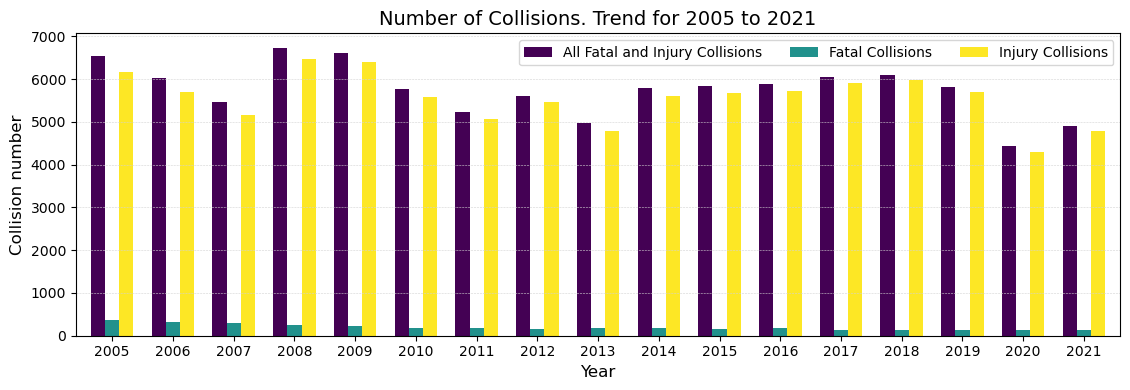

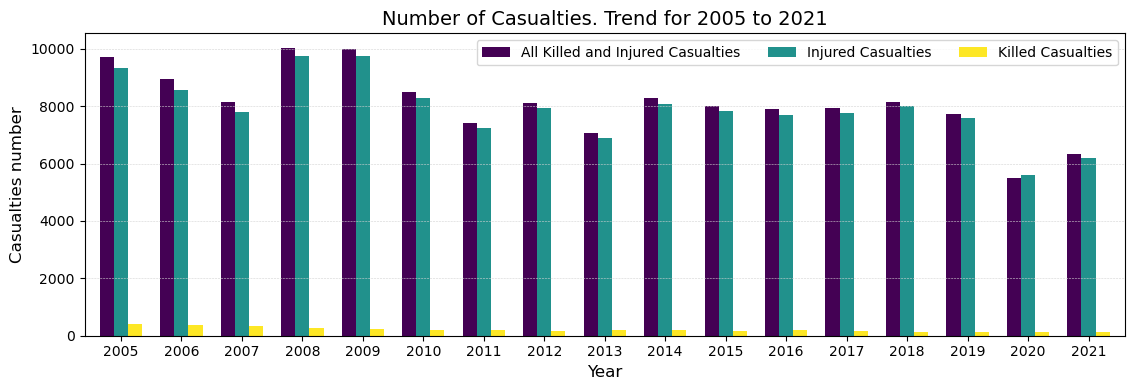

In [24]:
filtered_collisions = df_ie[df_ie['Statistic'].isin(Collisions)]
collisions = filtered_collisions.groupby(['Year', 'Statistic'])['value'].sum().unstack()

plt.figure()
plt.subplot(1,2,1)
collisions.plot(kind = 'bar', stacked = False, figsize = (22, 4), width=0.7, colormap = 'viridis', ax = plt.gca())

plt.title('Number of Collisions. Trend for 2005 to 2021', size = 14)
plt.xlabel('Year', size = 12)
plt.ylabel('Collision number', size = 12)
plt.legend(loc='best', ncols=3)
plt.xticks(rotation = 0)
plt.gca().yaxis.grid(True, color = 'lightgrey', linestyle = '--', linewidth = 0.4)
plt.gca().xaxis.grid(False)
plt.tight_layout() 


filtered_collisions = df_ie[df_ie['Statistic'].isin(Casualties)]
collisions = filtered_collisions.groupby(['Year', 'Statistic'])['value'].sum().unstack()

plt.figure()
plt.subplot(1,2,2)
collisions.plot(kind = 'bar', stacked = False, figsize = (22, 4), width=0.7, colormap = 'viridis', ax = plt.gca())

plt.title('Number of Casualties. Trend for 2005 to 2021', size = 14)
plt.xlabel('Year', size = 12)
plt.ylabel('Casualties number', size = 12)
plt.legend(loc='best', ncols=3)
plt.xticks(rotation = 0)
plt.gca().yaxis.grid(True, color = 'lightgrey', linestyle = '--', linewidth = 0.4)
plt.gca().xaxis.grid(False)

plt.tight_layout() 
plt.show()


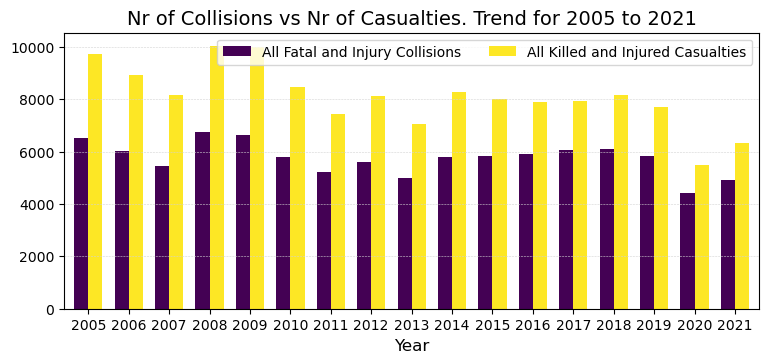

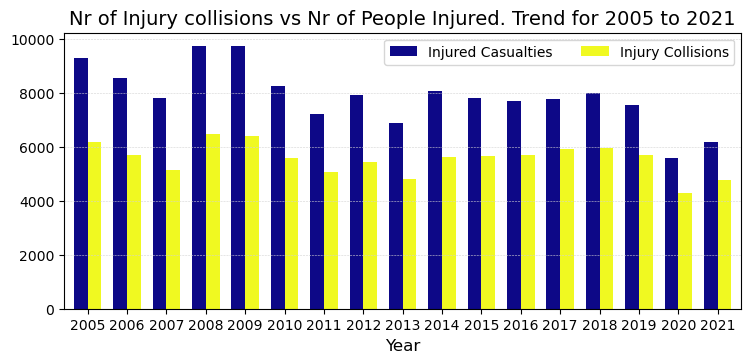

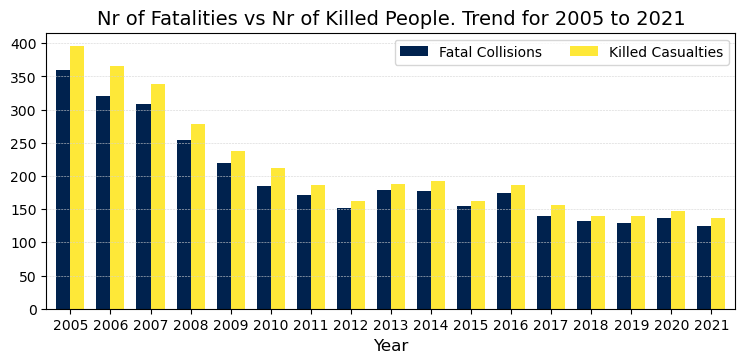

In [25]:
filtered_collisions = df_ie[df_ie['Statistic'].isin(All)]
ALL = filtered_collisions.groupby(['Year', 'Statistic'])['value'].sum().unstack()

plt.figure()
plt.subplot(3,3,1)
ALL.plot(kind = 'bar', stacked = False, figsize = (22, 10), width=0.7, colormap = 'viridis', ax = plt.gca())

plt.title('Nr of Collisions vs Nr of Casualties. Trend for 2005 to 2021', size = 14)
plt.xlabel('Year', size = 12)
plt.legend(loc='best', ncols=3)
plt.xticks(rotation = 0)
plt.gca().yaxis.grid(True, color = 'lightgrey', linestyle = '--', linewidth = 0.4)
plt.gca().xaxis.grid(False)
plt.tight_layout() 
plt.show()


filtered_collisions = df_ie[df_ie['Statistic'].isin(Injury)]
injury = filtered_collisions.groupby(['Year', 'Statistic'])['value'].sum().unstack()


plt.subplot(3,3,3)
injury.plot(kind = 'bar', stacked = False, figsize = (22, 10), width=0.7, colormap = 'plasma', ax = plt.gca())

plt.title('Nr of Injury collisions vs Nr of People Injured. Trend for 2005 to 2021', size = 14)
plt.xlabel('Year', size = 12)
plt.legend(loc='best', ncols=3)
plt.xticks(rotation = 0)
plt.gca().yaxis.grid(True, color = 'lightgrey', linestyle = '--', linewidth = 0.4)
plt.gca().xaxis.grid(False)
plt.tight_layout() 
plt.show()

filtered_collisions = df_ie[df_ie['Statistic'].isin(Killed)]
killed = filtered_collisions.groupby(['Year', 'Statistic'])['value'].sum().unstack()


plt.subplot(3,3,2)
killed.plot(kind = 'bar', stacked = False, figsize = (22, 10), width=0.7, colormap = 'cividis', ax = plt.gca())

plt.title('Nr of Fatalities vs Nr of Killed People. Trend for 2005 to 2021', size = 14)
plt.xlabel('Year', size = 12)
plt.legend(loc='best', ncols=3)
plt.xticks(rotation = 0)
plt.gca().yaxis.grid(True, color = 'lightgrey', linestyle = '--', linewidth = 0.4)
plt.gca().xaxis.grid(False)
plt.tight_layout()
plt.show()


In [26]:
rate = pd.merge(injury,ALL, on='Year', how='inner')
rate = pd.merge(rate, killed, on='Year', how='inner')

In [27]:
rate.tail(50)

Statistic,Injured Casualties,Injury Collisions,All Fatal and Injury Collisions,All Killed and Injured Casualties,Fatal Collisions,Killed Casualties
Year,,,,,,
2005,9318.0,6173.0,6533.0,9714.000000,360.0,396.0
2006,8575.0,5697.0,6018.0,8940.000000,321.0,365.0
2007,7806.0,5158.0,5467.0,8144.000000,309.0,338.0
2008,9758.0,6482.0,6736.0,10037.000000,254.0,279.0
2009,9742.0,6395.0,6615.0,9980.000000,220.0,238.0
2010,8270.0,5595.0,5780.0,8482.000000,185.0,212.0
2011,7235.0,5058.0,5230.0,7421.000000,172.0,186.0
2012,7942.0,5458.0,5610.0,8104.000000,152.0,162.0
2013,6880.0,4797.0,4976.0,7068.000000,179.0,188.0


In [28]:
rate['% Injured'] = round(rate['Injured Casualties']/rate['Injury Collisions'],2)
rate['% Killed'] = round(rate['Killed Casualties']/rate['Fatal Collisions'],2)
rate['% All'] = round(rate['All Killed and Injured Casualties']/rate['All Fatal and Injury Collisions'],2)
rate.head()

Statistic,Injured Casualties,Injury Collisions,All Fatal and Injury Collisions,All Killed and Injured Casualties,Fatal Collisions,Killed Casualties,% Injured,% Killed,% All
Year,,,,,,,,,
2005,9318.0,6173.0,6533.0,9714.0,360.0,396.0,1.51,1.10,1.49
2006,8575.0,5697.0,6018.0,8940.0,321.0,365.0,1.51,1.14,1.49
2007,7806.0,5158.0,5467.0,8144.0,309.0,338.0,1.51,1.09,1.49
2008,9758.0,6482.0,6736.0,10037.0,254.0,279.0,1.51,1.10,1.49
2009,9742.0,6395.0,6615.0,9980.0,220.0,238.0,1.52,1.08,1.51


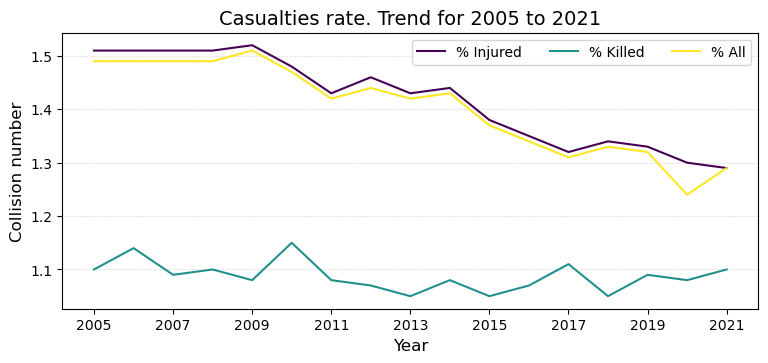

In [29]:
pc = rate.loc[:, ['% Injured', '% Killed', '% All']]
plt.figure()
plt.subplot(3,3,1)
pc.plot( figsize = (22, 10),  colormap = 'viridis', ax = plt.gca())

plt.title('Casualties rate. Trend for 2005 to 2021', size = 14)
plt.xlabel('Year', size = 12)
plt.ylabel('Collision number', size = 12)
plt.legend(loc='best', ncols=3)
plt.xticks(rotation = 0)
plt.gca().yaxis.grid(True, color = 'lightgrey', linestyle = '--', linewidth = 0.4)
plt.gca().xaxis.grid(False)
plt.tight_layout() 
plt.show()


In [30]:
#To work with 'Year' and 'Month of Year' as date let's transform them into date format.
df_ie['Year'] = df_ie['Year'].astype(str)
df_ie['Date'] = df_ie['Year'] + '-' + df_ie['Month of Year']
df_ie['Date'] = pd.to_datetime(df_ie['Date'],infer_datetime_format=True) #convert from string to datetime
df_ie = df_ie.drop(columns=['Year', 'Month of Year'])

**Note**

Let's save full data frame in the file for the future references

In [32]:
#Inspecting rest of categorical data
labels = df_ie.Statistic.unique()
labels

array(['Fatal Collisions', 'Injury Collisions',
       'All Fatal and Injury Collisions', 'Killed Casualties',
       'Injured Casualties', 'All Killed and Injured Casualties'],
      dtype=object)

**Note** 

To explore available trends, dependencies and create a deep understanding of available data let's expand data from rows to columns by using groupby() and unstack()


In [60]:
grouped = df_ie.groupby(['Date', 'Statistic'])['value'].sum().unstack()
grouped.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 204 entries, 2005-01-01 to 2021-12-01
Data columns (total 6 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   All Fatal and Injury Collisions    204 non-null    float64
 1   All Killed and Injured Casualties  204 non-null    float64
 2   Fatal Collisions                   204 non-null    float64
 3   Injured Casualties                 204 non-null    float64
 4   Injury Collisions                  204 non-null    float64
 5   Killed Casualties                  204 non-null    float64
dtypes: float64(6)
memory usage: 11.2 KB


In [64]:
grouped.to_csv("safety_ireland.csv", index = True)

In [62]:
grouped.head()

Statistic,All Fatal and Injury Collisions,All Killed and Injured Casualties,Fatal Collisions,Injured Casualties,Injury Collisions,Killed Casualties
Date,,,,,,
2005-01-01,473.0,716.0,31.0,683.0,442.0,33.0
2005-02-01,461.0,628.0,34.0,591.0,427.0,37.0
2005-03-01,498.0,744.0,23.0,718.0,475.0,26.0
2005-04-01,529.0,749.0,20.0,726.0,509.0,23.0
2005-05-01,561.0,841.0,36.0,800.0,525.0,41.0


In [40]:
def mpl_plot(avg, highlight):
    fig = Figure()
    FigureCanvas(fig) # not needed in mpl >= 3.1
    ax = fig.add_subplot()
    avg.plot(ax=ax)
    if len(highlight): highlight.plot(style='o', ax=ax)
    return fig

def find_outliers(variable='Fatal Collisions', window=12, sigma=1, view_fn=mpl_plot):
    avg = grouped[variable].rolling(window=window).mean()
    residual = grouped[variable] - avg
    std = residual.rolling(window=window).std()
    outliers = (np.abs(residual) > std * sigma)
    return view_fn(avg, avg[outliers])

In [41]:
kw = dict(window=(1, 60), variable=sorted(list(grouped.columns)), sigma=(1, 20))
def hvplot(avg, highlight):
    return avg.hvplot(height=300) * highlight.hvplot.scatter(color='orange', padding=0.1)

text2 = "## Collisions and Casualties\nSelect the parameter and the smoothing values"
hvp   = pn.interact(find_outliers, view_fn=hvplot, **kw)
pn.Column(pn.Row(pn.panel(text2, width=500), hvp[0]), hvp[1]).servable("Occupancy")

Column
    [0] Row
        [0] Markdown(str, width=500)
        [1] Column
            [0] Select(name='variable', options=['All Fatal and Injury Col...], value='Fatal Collisions')
            [1] IntSlider(end=60, name='window', start=1, value=12)
            [2] IntSlider(end=20, name='sigma', start=1, value=1)
    [1] Row(sizing_mode='fixed')
        [0] HoloViews(Overlay, height=300, name='interactive00808', sizing_mode='fixed', width=700)

**Note** 

* Geopandas Python package was used to visualize geospatial data with the aid of county boundaries dataset.
* Choropleth map was chosen to compare different regions effectively, color scheme gradient from light to dark based on public to private transport ratio clearly depicting the data.
* Plotting the ratio of killed people based on counties in Ireland was interesting to identify any patterns.

Reference

* https://geopandas.org/en/stable/
* https://prog.world/visualizing-geojson-data-using-geopandas-and-python/

Loading time may vary.

In [42]:
df = gpd.read_file('Counties_-_National_Statutory_Boundaries_-_2019.geojson')

https://data.gov.ie/dataset/counties-national-statutory-boundaries-2019

In [43]:
df.head()

,OBJECTID,CO_ID,ENGLISH,GAEILGE,LOGAINM_ID,GUID,CONTAE,COUNTY,PROVINCE,CENTROID_X,CENTROID_Y,AREA,SHAPE_Length,SHAPE_Area,geometry
0,1,50000,DONEGAL,Dún na nGall,100013,2ae19629-1452-13a3-e055-000000000001,Dún na nGall,DONEGAL,Ulster,607296.31,911848.45,4.860754e+09,23.413054,0.681241,"MULTIPOLYGON (((-8.08145 55.15957, -8.08144 55..."
1,2,120000,LIMERICK,Luimneach,100022,2ae19629-1440-13a3-e055-000000000001,Luimneach,LIMERICK,Munster,548318.75,640943.05,2.754926e+09,4.766632,0.364631,"MULTIPOLYGON (((-8.50852 52.74196, -8.50851 52..."
2,3,80000,KILDARE,Cill Dara,100007,2ae19629-1455-13a3-e055-000000000001,Cill Dara,KILDARE,Leinster,678993.60,712090.40,1.694083e+09,3.632523,0.227785,"MULTIPOLYGON (((-6.49499 53.35338, -6.49486 53..."
3,4,220000,WATERFORD,Port Láirge,100026,2ae19629-144b-13a3-e055-000000000001,Port Láirge,WATERFORD,Munster,630336.80,599955.37,1.857038e+09,5.543357,0.244035,"MULTIPOLYGON (((-7.59463 52.09696, -7.59459 52..."
4,5,260000,DUBLIN,Baile Átha Cliath,100002,2ae19629-144f-13a3-e055-000000000001,Baile Átha Cliath,DUBLIN,Leinster,714929.28,740960.44,9.257609e+08,4.487794,0.125039,"MULTIPOLYGON (((-6.45116 53.39150, -6.45115 53..."


In [48]:
# Convert 'COUNTY' values from Uppercase to Title case
df['COUNTY'] = df['COUNTY'].str.title()

In [49]:
data1 = pd.read_csv('by_county_2005_2012.csv')
grouped1 = data1.groupby(['County', 'Statistic Label'])['VALUE'].sum().unstack()
grouped1['% Killed'] = round(grouped1['Killed Casualties']/grouped1['Fatal Collisions'],2)
# Reset index
grouped1 = grouped1.reset_index()
grouped1 = grouped1[(grouped1['County'] != 'All Counties')]
grouped1.head()

Statistic Label,County,All Fatal and Injury Collisions,All Killed and Injured Casualties,Fatal Collisions,Injured Casualties,Injury Collisions,Killed Casualties,% Killed
1,Carlow,557,839,32,806,525,33,1.03
2,Cavan,1049,1650,65,1584,984,66,1.02
3,Clare,1224,1883,52,1828,1172,55,1.06
4,Cork,5029,7268,199,7054,4830,214,1.08
5,Donegal,2121,3491,104,3359,2017,132,1.27


In [50]:
map_ie1 = pd.merge(grouped1, df, how = 'outer', left_on = 'County', right_on = 'COUNTY')
map_ie1.sample(5)

,County,All Fatal and Injury Collisions,All Killed and Injured Casualties,Fatal Collisions,Injured Casualties,Injury Collisions,Killed Casualties,% Killed,OBJECTID,CO_ID,...,GUID,CONTAE,COUNTY,PROVINCE,CENTROID_X,CENTROID_Y,AREA,SHAPE_Length,SHAPE_Area,geometry
10,Laois,863.0,1347.0,44.0,1293.0,819.0,54.0,1.23,23.0,100000,...,2ae19629-143e-13a3-e055-000000000001,Laois,Laois,Leinster,644908.26,694308.36,1.719127e+09,3.307840,0.230078,"MULTIPOLYGON (((-7.08974 53.00100, -7.08971 53..."
11,Leitrim,407.0,618.0,23.0,591.0,384.0,27.0,1.17,20.0,110000,...,2ae19629-143f-13a3-e055-000000000001,Liatroim,Leitrim,Connacht,599762.02,821266.52,1.588030e+09,3.885969,0.218378,"MULTIPOLYGON (((-7.97939 53.89057, -7.97963 53..."
5,Dublin,10944.0,14214.0,196.0,14008.0,10748.0,206.0,1.05,5.0,260000,...,2ae19629-144f-13a3-e055-000000000001,Baile Átha Cliath,Dublin,Leinster,714929.28,740960.44,9.257609e+08,4.487794,0.125039,"MULTIPOLYGON (((-6.45116 53.39150, -6.45115 53..."
26,Wicklow,1422.0,2203.0,46.0,2156.0,1376.0,47.0,1.02,8.0,250000,...,2ae19629-144e-13a3-e055-000000000001,Cill Mhantáin,Wicklow,Leinster,707784.79,690738.10,2.025161e+09,3.813169,0.270939,"MULTIPOLYGON (((-6.14602 52.78372, -6.14607 52..."
16,Meath,2100.0,3125.0,103.0,3014.0,1997.0,111.0,1.08,14.0,160000,...,2ae19629-1444-13a3-e055-000000000001,An Mhí,Meath,Leinster,680723.14,767236.28,2.342049e+09,4.893508,0.318153,"MULTIPOLYGON (((-6.42888 53.72047, -6.42855 53..."


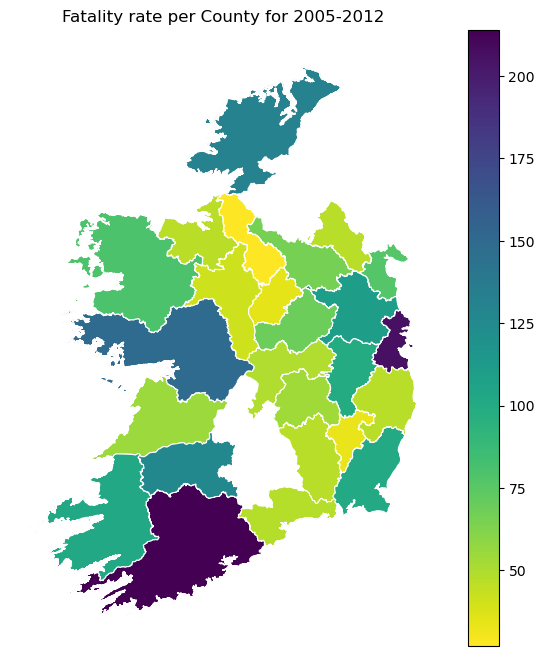

In [51]:
# Convert the dataset into a GeoDataFrame
map_df1 = gpd.GeoDataFrame(map_ie1, geometry = map_ie1['geometry'])

# Plotting the choropleth map
fig, ax = plt.subplots(1, figsize = (8, 8))
map_df1.plot(column = 'Killed Casualties', cmap = 'viridis_r', linewidth=0.8, ax = ax, edgecolor = '1', legend = True)

# Remove the axis
ax.axis('off')

# Add a title
ax.set_title('Fatality rate per County for 2005-2012', fontdict = {'fontsize': '12'})
             
# Display the map
plt.show()

In [53]:
data = pd.read_csv('by_county_2013_2023.csv')
grouped = data.groupby(['County', 'Statistic Label'])['VALUE'].sum().unstack()
grouped['% Killed'] = round(grouped['Killed Casualities']/grouped['Fatal Collisions'],2)
# Reset index
grouped = grouped.reset_index()
grouped = grouped[(grouped['County'] != 'All Counties')]
grouped.head()

Statistic Label,County,All Fatal and Injury Collisions,All Killed and Injured Casualities,Fatal Collisions,Injured Casualites,Injury Collisions,Killed Casualities,% Killed
1,Carlow,525,770,20,749,505,21,1.05
2,Cavan,931,1375,25,1349,906,26,1.04
3,Clare,993,1418,30,1385,963,33,1.10
4,Cork,5028,6613,140,6467,4888,146,1.04
5,Donegal,1825,2778,70,2694,1755,84,1.20


In [54]:
map_ie = pd.merge(grouped, df, how = 'outer', left_on = 'County', right_on = 'COUNTY')
map_ie.sample(5)

,County,All Fatal and Injury Collisions,All Killed and Injured Casualities,Fatal Collisions,Injured Casualites,Injury Collisions,Killed Casualities,% Killed,OBJECTID,CO_ID,...,GUID,CONTAE,COUNTY,PROVINCE,CENTROID_X,CENTROID_Y,AREA,SHAPE_Length,SHAPE_Area,geometry
7,Kerry,1723,2485,70,2411,1653,74,1.06,10,70000,...,2ae19629-1454-13a3-e055-000000000001,Ciarraí,Kerry,Munster,469696.21,600519.77,4.812989e+09,18.438930,0.631513,"MULTIPOLYGON (((-10.27649 52.13668, -10.27643 ..."
15,Mayo,1246,1860,63,1791,1183,69,1.10,17,150000,...,2ae19629-1443-13a3-e055-000000000001,Maigh Eo,Mayo,Connacht,504948.11,797843.38,5.587525e+09,20.664991,0.764265,"MULTIPOLYGON (((-9.92634 54.21208, -9.92629 54..."
21,Tipperary,1524,2173,88,2082,1436,91,1.03,25,210000,...,2ae19629-144a-13a3-e055-000000000001,Tiobraid Árann,Tipperary,Munster,605191.54,659297.87,4.303396e+09,6.151624,0.571522,"MULTIPOLYGON (((-7.75154 52.34101, -7.75166 52..."
13,Longford,532,859,23,836,509,23,1.00,13,130000,...,2ae19629-1441-13a3-e055-000000000001,An Longfort,Longford,Leinster,619420.92,775835.13,1.091078e+09,2.539273,0.148524,"MULTIPOLYGON (((-7.87938 53.78283, -7.88051 53..."
2,Clare,993,1418,30,1385,963,33,1.10,26,30000,...,2ae19629-1450-13a3-e055-000000000001,An Clár,Clare,Munster,524790.20,680078.02,3.448615e+09,6.637180,0.459996,"MULTIPOLYGON (((-8.74003 52.67553, -8.74203 52..."


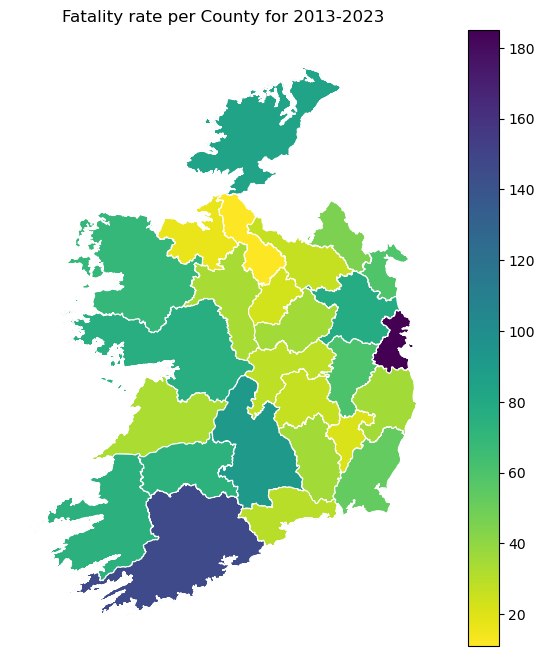

In [55]:
# Convert the dataset into a GeoDataFrame
map_df = gpd.GeoDataFrame(map_ie, geometry = map_ie['geometry'])

# Plotting the choropleth map
fig, ax = plt.subplots(1, figsize = (8, 8))
map_df.plot(column = 'Killed Casualities', cmap = 'viridis_r', linewidth=0.8, ax = ax, edgecolor = '1', legend = True)

# Remove the axis
ax.axis('off')

# Add a title
ax.set_title('Fatality rate per County for 2013-2023', fontdict = {'fontsize': '12'})
             
# Display the map
plt.show()

**Note** 

From the visualisation it's clear to see that central part of the country is more safe in terms of number of people killed in accidents.


<a class="anchor" id="2"></a>
# 2. Ireland's road safety analysis using time series
[Back to Table of Contents](#0.1)

- Statisctical methods: adfuller, shapiro test, autocorrelation and partial autocorrelation, ARIMA (AR, MA, ARIMA), AutoARIMA forecasting
- For the Machine learning: Linear Regression, Random Forest, Decission Tree, one hot encoder, reshaping, lags, CROSS-validation, Ridge, Polinomial Features, Gradient Boosted Tree.

<a class="anchor" id="2.1"></a>
### 2.1 Data load

[Back to Table of Contents](#0.1)

In [65]:
#Load data from previously safed csv file
dfm = pd.read_csv('safety_ireland.csv')
dfm.head()

,Date,All Fatal and Injury Collisions,All Killed and Injured Casualties,Fatal Collisions,Injured Casualties,Injury Collisions,Killed Casualties
0,2005-01-01,473.0,716.0,31.0,683.0,442.0,33.0
1,2005-02-01,461.0,628.0,34.0,591.0,427.0,37.0
2,2005-03-01,498.0,744.0,23.0,718.0,475.0,26.0
3,2005-04-01,529.0,749.0,20.0,726.0,509.0,23.0
4,2005-05-01,561.0,841.0,36.0,800.0,525.0,41.0


**Note**

At this stage, the data are:
1. omogen 
2. with the same number of observation for each feature
3. doesn't have any missing values
4. time interval: Jan-2005 - Dec-2021

**Challenge 1**

    * Traffic Volume - would be a great feature to have for the inspection as one of the closest correlation indicator. 
      Unfortunately, none of the available data sources provides traffic volume data in year-month format. There is only 
      data aggregated by year on CSO website and daily data for the last couple of years on TII website. 



<a class="anchor" id="2.2"></a>
### 2.2 Data Exploration

[Back to Table of Contents](#0.1)


The  next step is to inspect statisticaly available data and perform the time series analysis. The rational behind is that: 

- A **Time Series** is defined as a series of data points recorded at different time intervals. The time order can be daily, monthly, quarterly, yearly, etc..

- Time Series forecasting is the process of using a statistical model to predict future values of a time series based on past results.

In [66]:
df = pd.DataFrame(grouped, columns = ['Fatal Collisions'])
df.tail()

,Fatal Collisions
Date,
2021-08-01,16.0
2021-09-01,11.0
2021-10-01,12.0
2021-11-01,3.0
2021-12-01,17.0


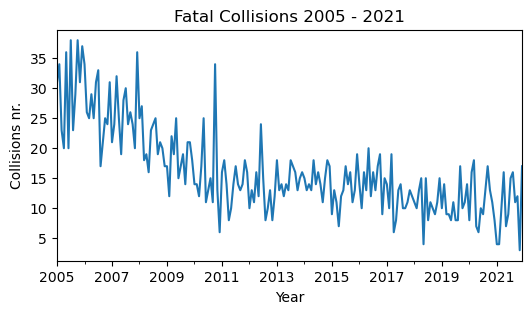

In [67]:
# Plot the time series 
ax = df.plot( figsize=(6,3))
ax.set_xlabel('Year')
ax.set_ylabel('Collisions nr.')
ax.set_title('Fatal Collisions 2005 - 2021')
ax.legend().remove()
plt.show()

Plot histogram (frequency of counts) and kernel density
* A density plot shows the distribution of the data over a continuous interval. 
* Kernel density plot smoothes out the noise in time series data.
* The peaks of a density plot help display where values are concentrated over the interval.
* A Kernel density plot is a a better way to display the distribution because it's not affected by the number of bins used (each bar used in a typical histogram).


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


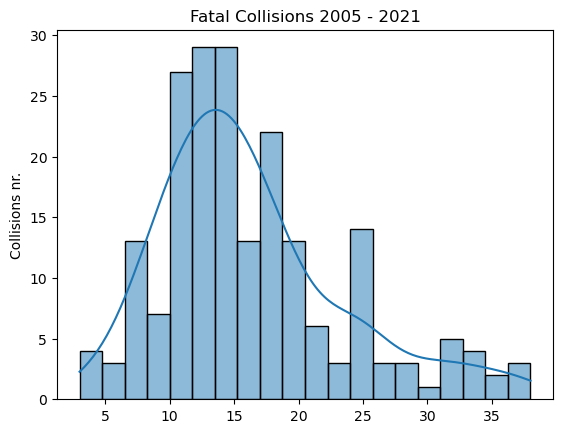

In [68]:
ax = sns.histplot(df, kde=True,bins=20)
ax.set_ylabel('Collisions nr.')
ax.set_title('Fatal Collisions 2005 - 2021')
ax.legend().remove()
plt.show()

<a class="anchor" id="2.3"></a>
### 2.3 Forecasting a time series
[Back to Table of Contents](#0.1)

Forecasting a time series can be broadly divided into two types:

1. If we use only the previous values of the time series to predict its future values, it is called **Univariate Time Series Forecasting.**

2. If we use predictors other than the series (like exogenous variables) to forecast it is called **Multi Variate Time Series Forecasting.**

Our dataset contain only values for the previous time period, so next analysis will be focuses on a particular type of forecasting method called **ARIMA modeling.**:


- **ARIMA** stands for **Autoregressive Integrated Moving Average Model**. It belongs to a class of models that explains a given time series based on its own past values -i.e.- its own lags and the lagged forecast errors. The equation can be used to forecast future values. Any ‘non-seasonal’ time series that exhibits patterns and is not a random white noise can be modeled with ARIMA models.
- **ARIMA**, short for **AutoRegressive Integrated Moving Average**, is a forecasting algorithm based on the idea that the information in the past values of the time series can alone be used to predict the future values.
- **ARIMA Models** are specified by three order parameters: (p, d, q), 

   where,

   - p is the order of the AR term

   - q is the order of the MA term

   - d is the number of differencing required to make the time series stationary


<a class="anchor" id="2.3.1"></a>
### 2.3.1 Augmented Dickey–Fuller test

[Back to Table of Contents](#0.1)


Now, let's apply the concept on our data:
- First, I let's check if the series is stationary using the **Augmented Dickey Fuller test (ADF Test)**, from the statsmodels package. The reason being is that we need differencing only if the series is non-stationary. Else, no differencing is needed, that is, **d=0**.


- The null hypothesis (Ho) of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then we reject the null hypothesis and infer that the time series is indeed stationary.


- So, in our case, if P Value > 0.05 we go ahead with finding the order of differencing.


##### H0 - Data are nonstationary
##### H1 - Data are stationaty

In [69]:
result = adfuller(df['Fatal Collisions'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.037510
p-value: 0.270372


- Since p-value(0.3) is greater than the significance level(0.05), so we accept our H0 and should continue with differences.
Let’s difference the series and see how the autocorrelation plot looks like.

<a class="anchor" id="2.3.2"></a>
### 2.3.2 Finding parameters for the ARIMA model

[Back to Table of Contents](#0.1)

**Differencing, Autocorrelation and Partial Autocorrelation**

As stated, the purpose of differencing is to make the time series stationary. But we should be careful to not over-difference the series. An over differenced series may still be stationary, which in turn will affect the model parameters. So we should determine the right order of differencing. The right order of differencing is the minimum differencing required to get a near-stationary series which roams around a defined mean and the ACF plot reaches to zero fairly quick.

* If the autocorrelations are positive for many number of lags (10 or more), then the series needs further differencing. On the other hand, if the lag 1 autocorrelation itself is too negative, then the series is probably over-differenced.

* If we can’t really decide between two orders of differencing, then we go with the order that gives the least standard deviation in the differenced series.

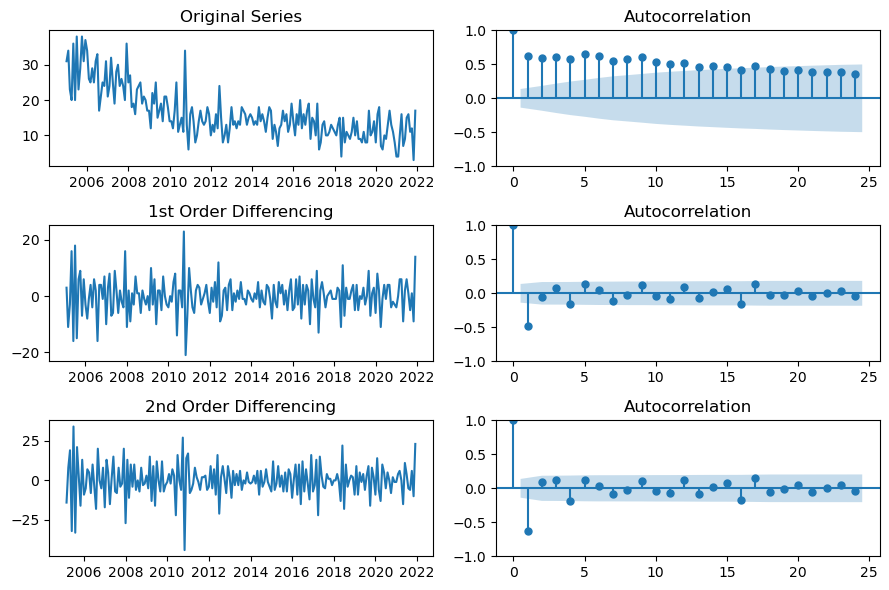

In [70]:
# Original Series
fig, axes = plt.subplots(3, 2,figsize=(9, 6))
axes[0, 0].plot(df); axes[0, 0].set_title('Original Series')
plot_acf(df, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.diff().diff().dropna(), ax=axes[2, 1])
plt.tight_layout() 

plt.show()

**Note** 

For the above data, we can see that the time series reaches stationarity with two orders of differencing. **d=1**

The **next step** is to identify if the model needs any AR terms. We will find out the required number of AR terms by inspecting the **Partial Autocorrelation (PACF) plot**.

**Partial autocorrelation** can be imagined as the correlation between the series and its lag, after excluding the contributions from the intermediate lags. So, PACF sort of conveys the pure correlation between a lag and the series. This way, we will know if that lag is needed in the AR term or not. Partial autocorrelation of lag (k) of a series is the coefficient of that lag in the autoregression equation of Y.


$$Yt = \alpha0 + \alpha1 Y{t-1} + \alpha2 Y{t-2} + \alpha3 Y{t-3}$$


If Y_t is the current series and Y_t-1 is the lag 1 of Y, then the partial autocorrelation of lag 3 (Y_t-3) is the coefficient $\alpha_3$ of Y_t-3 in the above equation. 

Now, we should find the number of AR terms. Any autocorrelation in a stationarized series can be rectified by adding enough AR terms. So, we initially take the order of AR term to be equal to as many lags that crosses the significance limit in the PACF plot.

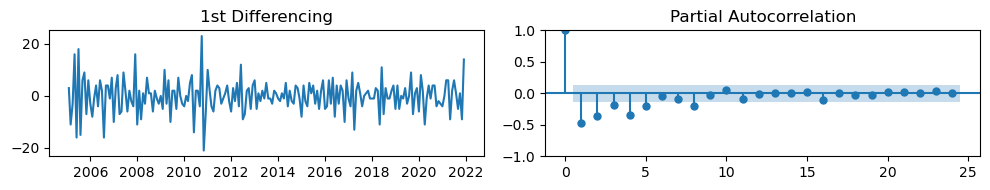

In [72]:
# PACF plot of 1st differenced series
fig, axes = plt.subplots(1, 2, figsize=(10, 2))
axes[0].plot(df.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.diff().dropna(), ax=axes[1])
plt.tight_layout() 
plt.show()

**Note** 

We can see that the PACF first 4 to 6 lags are quite significant since it is well below the significance line. So, we will fix the value of **p as 4**
***


**q** is the order of the Moving Average (MA) term. It refers to the number of lagged forecast errors that should go into the ARIMA Model.

Just like how we looked at the PACF plot for the number of AR terms, we will look at the ACF plot for the number of MA terms. An MA term is technically, the error of the lagged forecast. The ACF tells how many MA terms are required to remove any autocorrelation in the stationarized series.

Let’s see the autocorrelation plot of the differenced series.

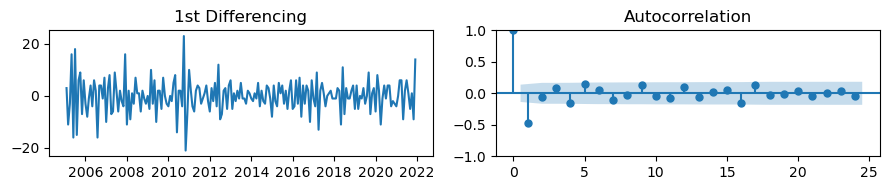

In [73]:
fig, axes = plt.subplots(1, 2, figsize=(9, 2))
axes[0].plot(df.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df.diff().dropna(), ax=axes[1])
plt.tight_layout() 
plt.show()

**Note** 

The first lag is below the significance line. q will be fixed at 1 (q=1)

 <a class="anchor" id="2.4"></a>
### 2.4 Building Auto Arima Forecasting 


[Back to Table of Contents](#0.1)


- In Python, the `pmdarima` package provides `auto_arima()` function which can be used to automate the process of ARIMA Forecasting in Python.

- `auto_arima()` uses a stepwise approach to search multiple combinations of p,d,q parameters and chooses the best model that has the least AIC.

- We need to install the `pmdarima` package first.

In [74]:
#!pip install pmdarima

In [76]:
# Create Training and Test
train = df[:155]
test = df[155:]

In [77]:
actual = test.iloc[:, 0]
actual

Date
2017-12-01    12.0
2018-01-01    11.0
2018-02-01    10.0
2018-03-01    13.0
2018-04-01    15.0
2018-05-01     4.0
2018-06-01    15.0
2018-07-01     8.0
2018-08-01    11.0
2018-09-01    10.0
2018-10-01     9.0
2018-11-01    11.0
2018-12-01    15.0
2019-01-01    10.0
2019-02-01    14.0
2019-03-01     9.0
2019-04-01     9.0
2019-05-01     8.0
2019-06-01    11.0
2019-07-01     8.0
2019-08-01     8.0
2019-09-01    17.0
2019-10-01    10.0
2019-11-01    11.0
2019-12-01    14.0
2020-01-01     8.0
2020-02-01    16.0
2020-03-01    18.0
2020-04-01     7.0
2020-05-01     6.0
2020-06-01    10.0
2020-07-01     9.0
2020-08-01    13.0
2020-09-01    17.0
2020-10-01    13.0
2020-11-01    11.0
2020-12-01     8.0
2021-01-01     4.0
2021-02-01     4.0
2021-03-01    10.0
2021-04-01    16.0
2021-05-01     7.0
2021-06-01     9.0
2021-07-01    15.0
2021-08-01    16.0
2021-09-01    11.0
2021-10-01    12.0
2021-11-01     3.0
2021-12-01    17.0
Name: Fatal Collisions, dtype: float64

In [78]:
model = pm.auto_arima(df, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=4, max_q=2, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1194.079, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1318.283, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1266.315, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1192.679, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1316.308, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1193.928, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1196.304, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 1.328 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  204
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -593.340
Date:                Tue, 02 Jan 2024   AIC                           1192.679
Time:                        18:56:57   B

 <a class="anchor" id="2.4.1"></a>
### 2.4.1 Plot diagnostics

[Back to Table of Contents](#0.1)

Let’s review the residual plots using stepwise_fit.

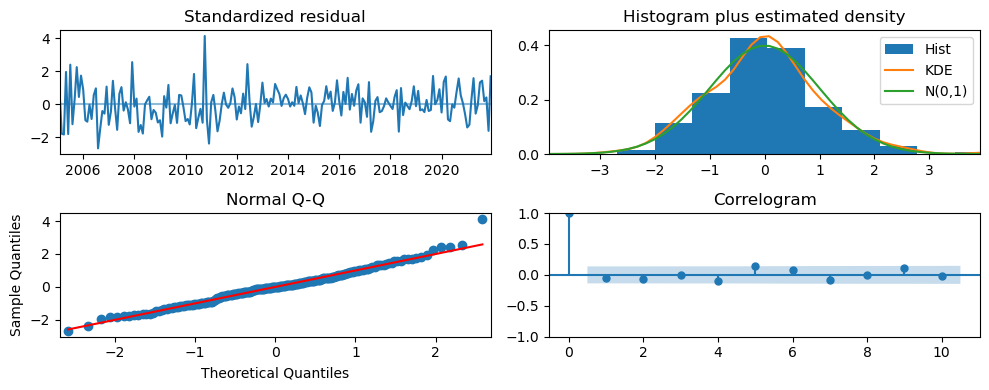

In [80]:
model.plot_diagnostics(figsize=(10,4))
plt.tight_layout()
plt.show()

<a class="anchor" id="2.4.2"></a>
### 2.4.2 Interpretation of plots

[Back to Table of Contents](#0.1)


**Standardized residual**: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.


**Histogram**: The density plot suggest normal distribution with mean slighlty shifted towards right.


**Theoretical Quantiles**: Mostly the dots fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.


**Correlogram**: The Correlogram, (or ACF plot) shows the residual errors are not autocorrelated. The ACF plot would imply that there is some pattern in the residual errors which are not explained in the model. So we will need to look for more X’s (predictors) to the model.


Overall, the model seems to be a good fit. So, let's use it to forecast.

<a class="anchor" id="2.4.3"></a>
### 2.4.3 Forecast

[Back to Table of Contents](#0.1)

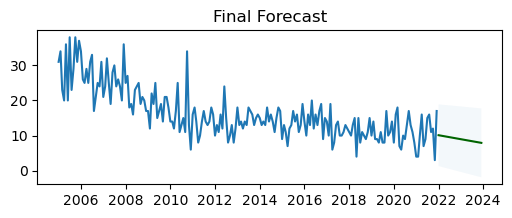

In [81]:

n_periods = 24
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.concatenate([df.index, fc.index])

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], fc.index)
upper_series = pd.Series(confint[:, 1], fc.index)

# Plot
plt.figure(figsize=(6, 2))
plt.plot(df)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, lower_series, upper_series, alpha=0.05)

plt.title("Final Forecast")
plt.show()

<a class="anchor" id="2.5"></a>
# 2.5 Machine learning modeling for time series

[Back to Table of Contents](#0.1)

In this section different machine learning models will be applied for time-series prediction.

Same dataset will be used, i.e. All number of collision for period of time from 2005-2021

***For the machine learning modeling part, a colorblind-friendly palette will be utilized, incorporating default blue-orange colors that are easily distinguishable for individuals with colorblindness.***

* https://scottplot.net/cookbook/4.1/colors/#colorblind-friendly

In [82]:
df = pd.DataFrame(grouped, columns = ['Injury Collisions'])
df.describe()

,Injury Collisions
count,204.000000
mean,463.196078
std,71.919638
min,132.000000
25%,426.750000
50%,468.500000
75%,509.000000
max,611.000000


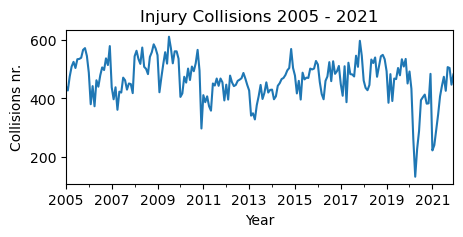

In [83]:
# line plot of dataset
ax = df.plot(figsize=(5,2))
ax.set_xlabel('Year')
ax.set_ylabel('Collisions nr.')
ax.set_title('Injury Collisions 2005 - 2021')
ax.legend().remove()
plot.show()

<a class="anchor" id="2.5.1"></a>
### 2.5.1 Splitting and reshaping the data

[Back to Table of Contents](#0.1)

In [84]:
#Splitting and reshaping the data
ys = df['Injury Collisions']
y = ys.values
X = df.index.astype("int64").values.reshape(-1, 1) // 10**9
X.shape, y.shape

((204, 1), (204,))

In [85]:
# use the first 145 data points for training and the rest for testing (it will be about 70/30 proportion)
n_train = 145
xticks = pd.date_range(start = ys.index.min(), end = ys.index.max(), freq = 'M')

<a class="anchor" id="2.5.2"></a>
### 2.5.2 Creating a function to evaluate and plot a regressor

[Back to Table of Contents](#0.1)

In [86]:
score = []
# function to evaluate and plot a regressor on a given feature set
def eval_on_features(features, target, regressor):
    # split the given features into a training and a test set
    X_train, X_test = features[:n_train], features[n_train:]
    # also split the target array
    y_train, y_test = target[:n_train], target[n_train:]    
    regressor.fit(X_train, y_train)
    print("Score: {:.2f}".format(regressor.score(X_test, y_test)))
    y_pred = regressor.predict(X_test)
    y_pred_train = regressor.predict(X_train)
    plt.figure(figsize = (10, 3))
    
    plt.xticks(range(0, len(X), 16), [date.strftime("%Y") for date in xticks[::16]])

    plt.plot(range(n_train), y_train, label = "train", color = '#0072B2')
    plt.plot(range(n_train, len(y_test) + n_train), y_test, '-', label = "test", color = '#F0E442')
    plt.plot(range(n_train), y_pred_train, '--', label = "prediction train", color = '#56B4E9')
    plt.plot(range(n_train, len(y_test) + n_train), y_pred, '--', label = "prediction test", color = '#D55E00')
    plt.legend(loc = (1.01, 0))
    plt.xlabel("Date")
    plt.ylabel("Rentals")
    score = regressor.score(X_test, y_test)
    return score

<a class="anchor" id="2.5.3"></a>
### 2.5.3 Random Forest

[Back to Table of Contents](#0.1)

Score: -0.06


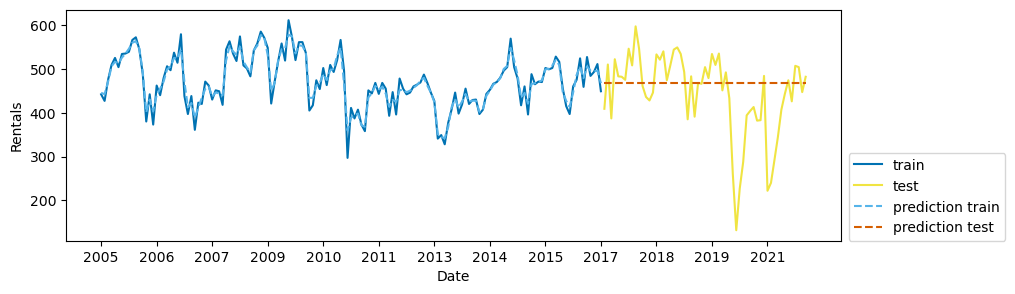

In [87]:
# Create an object 'regressor' by calling a method RandomForestRegressor()
random_forest = RandomForestRegressor(n_estimators = 100, random_state = 0)

# Call the method eval_on_features() to calculate the R^2 and plot

score.append(eval_on_features(X, y, random_forest))

**Note**
For the Random Forest algorithm acuracy score is negative, thus we have our model overfitting. Let's reshape our monthly data and try again.

Score: 0.13


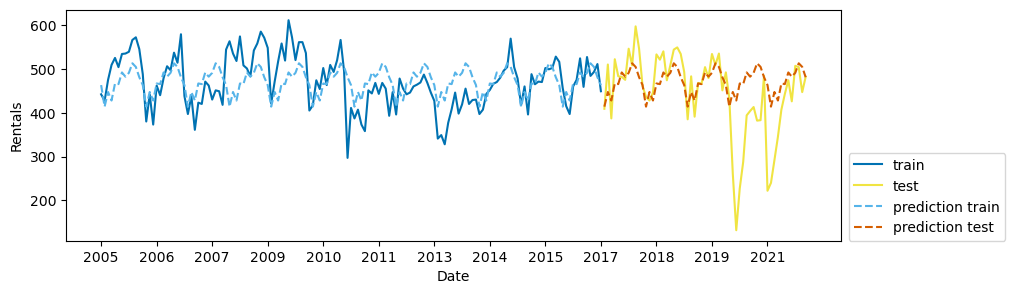

In [88]:
# Store the data hourly in X_hour and make one column using reshape(-1, 1)
X_hour = ys.index.month.values.reshape(-1, 1)
# Call a method eval_on_features() to evaluate R^2 and plot
score.append(eval_on_features(X_hour, y, random_forest))

**Note** 
From the graph we can see that our model is doing much better, however prediction score is extremely low. Let's include 'year' in the reshaping and try again.

Score: 0.16


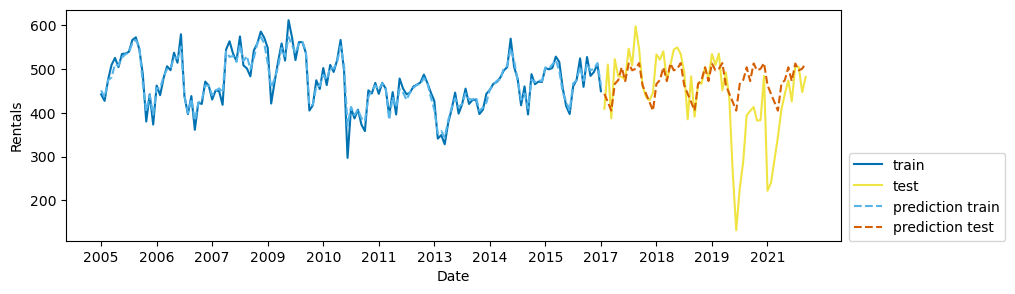

In [89]:
# Store the hourly data weekly in X_hour_week and make one column using reshape(-1, 1)
X_month_year = np.hstack([ys.index.year.values.reshape(-1, 1), ys.index.month.values.reshape(-1, 1)])
# Call a method eval_on_features() to evaluate R^2 and plot
score.append(eval_on_features(X_month_year, y, random_forest))

**Note**
The accuracy score came back to negative number. Seems like Random Forest doesn't work for our data. Let's try Linear Regression.

<a class="anchor" id="2.5.4"></a>
### 2.5.4 Linear Regression

[Back to Table of Contents](#0.1)

Score: 0.21


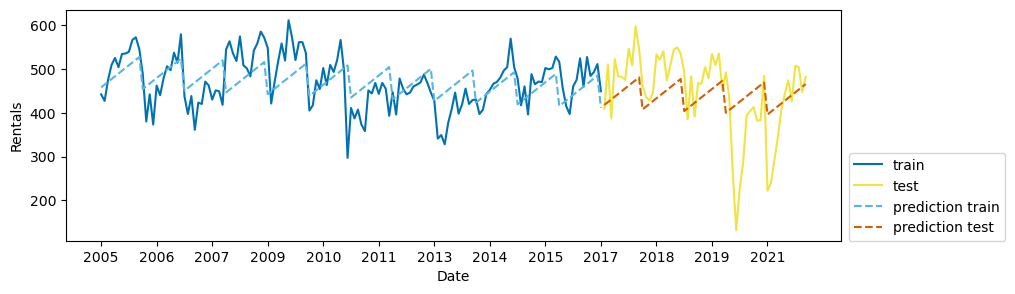

In [90]:
linear_regression = LinearRegression()

# Call a method eval_on_features() to evaluate R^2 and plot
score.append(eval_on_features(X_month_year, y, linear_regression))

**Note**
There is a need to tune our data as even Linear Regression model overfitting. Let's apply One Hot Encoder.

Score: -2719331625959518150112313344.00


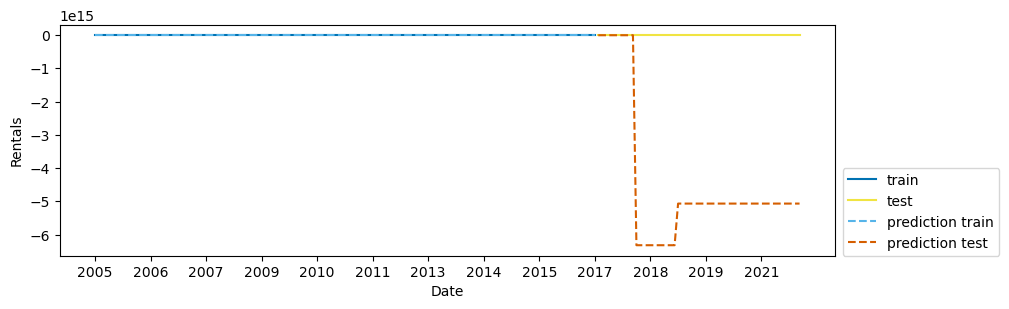

In [91]:
# Declare an object (enc) by calling a method OneHotEncoder()
enc = OneHotEncoder()

# Create an array by calling a fit() method
X_month_year_onehot = enc.fit_transform(X_month_year).toarray()

# Call a method eval_on_features() to evaluate R^2 and plot
score.append(eval_on_features(X_month_year_onehot, y, linear_regression))

**Note**
By applying One Hot Encoder we got absolutely unworkable model. It indicate that Linear Regression is a wrong direction.

Let's apply Ridge on our data.

<a class="anchor" id="2.5.5"></a>
### 2.5.5 Ridge

[Back to Table of Contents](#0.1)

Score: 0.12


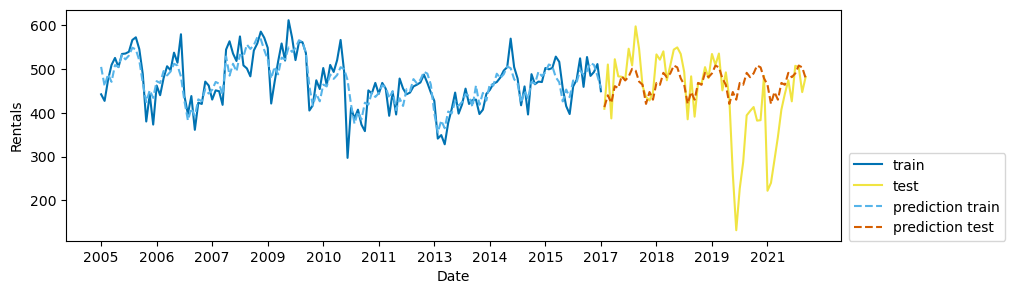

In [92]:
ridge = Ridge() 
# Call a method eval_on_features() to evaluate R^2 and plot 
score.append(eval_on_features(X_month_year_onehot, y, ridge))

**Note** 

There is an improvement in acuracy scorring, so let's try to higher the score by adding polynomial features for created Ridge model.

Score: 0.11


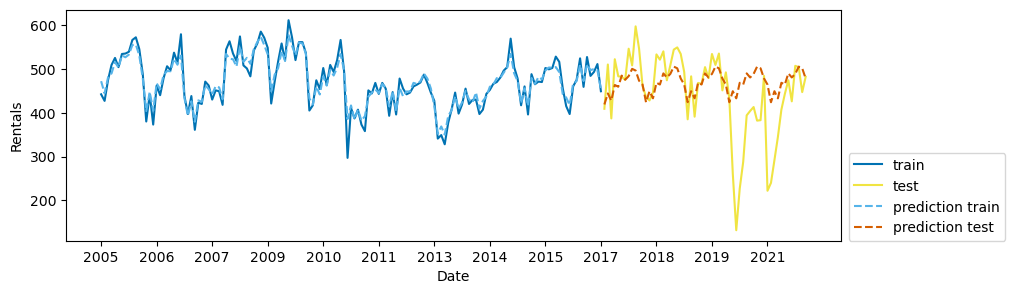

In [93]:
# Create and initialise an object named as PolynomialFeatures()
poly_transformer = PolynomialFeatures(degree = 2, interaction_only = True, include_bias = False)

# Call fit() method to train the model
X_month_year_onehot_poly = poly_transformer.fit_transform(X_month_year_onehot)

# Initialise an object by calling a method Ridge()
ridge = Ridge()

# Call a method eval_on_features() to evaluate R^2 and plot 
score.append(eval_on_features(X_month_year_onehot_poly, y, ridge))

**Note** 
Despite the data transformation with help of Polynomial Regression our model scorring didn't improve.

In [94]:
regressors = ['Random Forest', 'Random forest + month reshape', 'Random forest + month/year reshape', 
             'Linear Regresson', 'Linear Regression + OneHotEncoder', 'Ridge', 'Ridge + Polinomial Feature']

In the list of our scores we have negative numbers, that will be considered as 0 score for the model in the comparison graph

In [95]:
for i in range(len(score)):
    if score[i] < 0:
        score[i] = 0

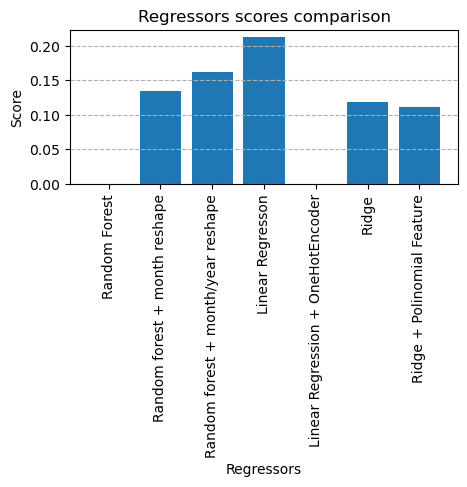

In [96]:
fig, ax = plt.subplots(figsize=(5,2))
plt.bar(range(len(score)), score)

# Setting the ticks on the x-axis using the string list
plt.xticks(range(len(regressors)), regressors, rotation = 90)
plt.grid(axis='y', linestyle = '--')
# Adding labels and title
plt.xlabel('Regressors')
plt.ylabel('Score')
plt.title('Regressors scores comparison')
# Display the plot
plt.show()

<a class="anchor" id="2.5.6"></a>
## 2.5.6 Lags on time series

One more common approach that we can try on the time series data is to create lags (12 for our specific case, as the data are monthly).

[Back to Table of Contents](#0.1)

In [97]:
df2 = pd.DataFrame()

In [98]:
# Create 12 months of lag values to predict current observation
# Shift of 12 months
for i in range(12,0,-1):
    df2[['t-'+str(i)]] = df.shift(i)
# Create column t
df2['t'] = df.values
print(df2.head(13))

             t-12   t-11   t-10    t-9    t-8    t-7    t-6    t-5    t-4  \
Date                                                                        
2005-01-01    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2005-02-01    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2005-03-01    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2005-04-01    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2005-05-01    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  442.0   
2005-06-01    NaN    NaN    NaN    NaN    NaN    NaN    NaN  442.0  427.0   
2005-07-01    NaN    NaN    NaN    NaN    NaN    NaN  442.0  427.0  475.0   
2005-08-01    NaN    NaN    NaN    NaN    NaN  442.0  427.0  475.0  509.0   
2005-09-01    NaN    NaN    NaN    NaN  442.0  427.0  475.0  509.0  525.0   
2005-10-01    NaN    NaN    NaN  442.0  427.0  475.0  509.0  525.0  504.0   
2005-11-01    NaN    NaN  442.0  427.0  475.0  509.0  525.0  504.0  534.0   

In [99]:
# Create a new subsetted dataframe, removing Nans from first 12 rows
df1 = df2[13:]

**Note**
Applying Decision tree algorithm. 

<a class="anchor" id="2.5.6.1"></a>
### 2.5.6.1 Decision tree

[Back to Table of Contents](#0.1)

In [100]:
# Split data

predict = df1.values
# split into lagged variables and original time series
X1= predict[:, 0:-1]  # slice all rows and start with column 0 and go up to but not including the last column
y1 = predict[:,-1]  # slice all rows and last column, essentially separating out 't' column

In [101]:
# Columns t-1 to t-12, which are the lagged variables
X1

array([[427., 475., 509., ..., 572., 545., 488.],
       [475., 509., 525., ..., 545., 488., 380.],
       [509., 525., 504., ..., 488., 380., 442.],
       ...,
       [382., 383., 484., ..., 474., 426., 507.],
       [383., 484., 222., ..., 426., 507., 504.],
       [484., 222., 240., ..., 507., 504., 447.]])

In [102]:
# Column t, which is the original time series
# Give first 10 values of target variable, time series
y1[0:10]

array([380., 442., 373., 462., 440., 479., 506., 497., 537., 514.])

In [103]:
# Target Train-Test split
Y1 = y1
traintarget_size = int(len(Y1) * 0.50)   # Set split
train_target, test_target = Y1[0:traintarget_size], Y1[traintarget_size:len(Y1)]
# Features Train-Test split
trainfeature_size = int(len(X1) * 0.50)
train_feature, test_feature = X1[0:trainfeature_size], X1[trainfeature_size:len(X1)]

In [104]:
lag_score = []

In [105]:
# Create a decision tree regression model with default arguments
DT = DecisionTreeRegressor()  # max-depth not set

# Fit the model to the training features and targets
DT.fit(train_feature, train_target)

# Check the score on train and test
print(DT.score(train_feature, train_target))
print(DT.score(test_feature,test_target))  

1.0
-0.042297104789410955


In [106]:
lag_score.append(DT.score(test_feature,test_target))

**Note** 

Despite the data modification we got negative score for prediction and 100% for our train part of data, so it's the overfitting again. Let's try tunning our model.

In [107]:
# Find the best Max Depth

# Loop through a few different max depths and check the performance
# Try different max depths. We want to optimize our ML models to make the best predictions possible.
# For regular decision trees, max_depth, which is a hyperparameter, limits the number of splits in a tree.
# You can find the best value of max_depth based on the R-squared score of the model on the test set.

for d in [2, 3, 4, 5,7,8,10]:
    # Create the tree and fit it
    DT = DecisionTreeRegressor(max_depth=d)
    DT.fit(train_feature, train_target)

    # Print out the scores on train and test
    print('max_depth=', str(d))
    print(DT.score(train_feature, train_target))
    print(DT.score(test_feature, test_target), '\n')  # You want the test score to be positive and high

max_depth= 2
0.5227924923408753
0.12459945790807903 

max_depth= 3
0.6032927602529768
0.037778531143015215 

max_depth= 4
0.7453049553291693
0.012337989281064443 

max_depth= 5
0.8652669645596132
-0.04406596225488735 

max_depth= 7
0.9644867132381941
-0.06483028063045637 

max_depth= 8
0.9899948559316568
-0.11379465909856856 

max_depth= 10
0.9996061777952309
-0.08686841635281106 



**Note** 
Almost all scores that we got are negative that lead us to overfitting conclussion. We got the best score in case of max depth = 2, but it's still very low to continue with current model.

Let's try **Random Forest** - the model that gave the highest positive score so far.

In [108]:
#Updating list with scores 
lag_score.append(0.12459945790807903)

<a class="anchor" id="2.5.6.2"></a>
### 2.5.6.2 Random Forest

[Back to Table of Contents](#0.1)

In [109]:
# Create the random forest model and fit to the training data
rfr = RandomForestRegressor(n_estimators=200)
rfr.fit(train_feature, train_target)

# Look at the R^2 scores on train and test
print(rfr.score(train_feature, train_target))
print(rfr.score(test_feature, test_target))  # Try to attain a positive value
lag_score.append(rfr.score(test_feature, test_target))

0.9134180335566078
0.24588339485536737


**Note**

0.265 -  highest positive score that we got so far. Let's try to continue with the model, but with different parameters.

One important aspect of tuning the hyperparameter is the number of features we sample at each split. This is the max_features in RandomForestRegressor from the sklearn library. For models like random forests that have randomness built-in, we also want to set the random_state. This is set for our results to be reproducible. We will use sklearn's ParameterGrid to create combinations of hyperparameters to search.

In [110]:
# Create a dictionary of hyperparameters to search
# n_estimators is the number of trees in the forest. The larger the better, 
# but also the longer it will take to compute. 
# Run grid search
# grid = {'n_estimators': [200], 'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10], 'max_features': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'random_state': [13]}
grid = {'n_estimators': [200], 'max_depth': [10], 'max_features': [7], 'random_state': [13]}
test_scores = []

# Loop through the parameter grid, set the hyperparameters, and save the scores
for g in ParameterGrid(grid):
    rfr.set_params(**g)  # ** is "unpacking" the dictionary
    rfr.fit(train_feature, train_target)
    test_scores.append(rfr.score(test_feature, test_target))

# Find best hyperparameters from the test score and print
best_idx = np.argmax(test_scores)
print(test_scores[best_idx], ParameterGrid(grid)[best_idx])  # You don't want negative value

# The best test score

lag_score.append(test_scores[best_idx])

0.2785218477917212 {'random_state': 13, 'n_estimators': 200, 'max_features': 7, 'max_depth': 10}


**Note** 
The score is still low, however this is already an improvement for our Random Forest model prediction.

We want to evaluate performance of our best model to check how well or poorly we are doing. We've already seen the R-squares scores, but let's take a look at the scatter plot of predictions vs actual results using matplotlib. Perfect predictions would be a diagonal line from the lower left to the upper right.

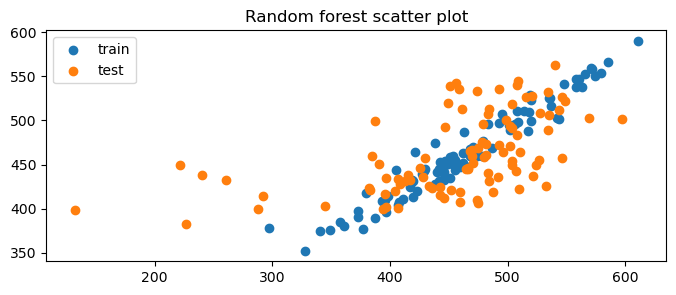

In [111]:
# Use the best hyperparameters from before to fit a random forest model
rfr = RandomForestRegressor(n_estimators=200, max_depth=10, max_features = 7, random_state=13)
rfr.fit(train_feature, train_target)

# Make predictions with our model
train_prediction = rfr.predict(train_feature)
test_prediction = rfr.predict(test_feature)

# Create a scatter plot with train and test actual vs predictions
fig, ax = plt.subplots(figsize=(8,3))
plot.scatter(train_target, train_prediction, label='train')
plot.scatter(test_target, test_prediction, label='test')
plot.legend()
plot.title(label='Random forest scatter plot')
plot.show()

As soon as this is our best model so far, let's continue to work with it.

Random Forest offers variable importance. This means that it will measure how much each feature contributes to our predictions. This is a way to reduce the number of features, particularly when dealing with a very large dataset. The will allow us to hone in on the important features.

.feature_importances_ property can be used after fitting a model. It stores the feature importance scores. The indices of the sorted feature importances will be used and np.argsort() to make a bar plot of feature importances (sorted from greatest to least importance).

In [112]:
# Random Forest Feature Importance
# get column names
df2.columns

Index(['t-12', 't-11', 't-10', 't-9', 't-8', 't-7', 't-6', 't-5', 't-4', 't-3',
       't-2', 't-1', 't'],
      dtype='object')

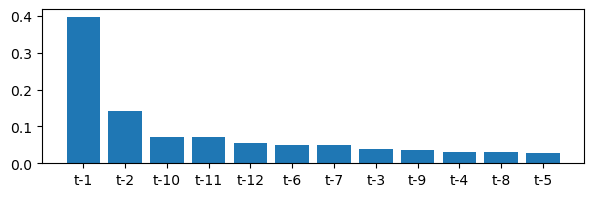

In [113]:
# Get feature importances from our random forest model
importances = rfr.feature_importances_

# Get the index of importances from greatest importance to least
sorted_index = np.argsort(importances)[::-1]
x = range(len(importances))

# Create tick labels 
feature_names = ['t-12', 't-11', 't-10', 't-9', 't-8', 't-7', 't-6', 't-5', 't-4', 't-3',
       't-2', 't-1']
labels = np.array(feature_names)[sorted_index]
fig, ax = plt.subplots(figsize=(7,2))
plot.bar(x, importances[sorted_index], tick_label=labels)

# Rotate tick labels to vertical
plot.xticks(rotation=0)
plot.show()


**Note** 

Here, we can see how much each lag variable gives in explanatory power. It shows the explanatory power for each lag in sorted order. It is similiar to the autocorrelation plot.

**Note** 
Let's try one more common model for the time series analysis - **Gradient Boosted Tree**

<a class="anchor" id="2.5.6.3"></a>
### 2.5.6.3 Gradient Boosted Tree

[Back to Table of Contents](#0.1)

In [114]:
# The fraction of samples to be used for fitting the individual base learners. 
# Choosing subsample < 1.0 leads to a reduction of variance and an increase in bias.
# Create GB model -- hyperparameters 
gbr = GradientBoostingRegressor(max_features=7,
                                learning_rate=0.01,
                                n_estimators=500,
                                subsample=0.6,
                                random_state=99)

gbr.fit(train_feature, train_target)

print(gbr.score(train_feature, train_target))
print(gbr.score(test_feature, test_target))

lag_score.append(gbr.score(test_feature, test_target))

0.9442517486679434
0.3193636619542607


The GB model performing better than Random Forest model.

We can extract feature importances from gradient boosting models to understand which features are the best predictors. Sometimes it's nice to try different tree-based models and look at the feature importances from all of them. This can help average out any peculiarities that may arise from one particular model.

The feature importances are stored as a numpy array in the .feature_importances_ property of the gradient boosting model. We'll need to get the sorted indices of the feature importances, using np.argsort(), in order to make a nice plot. We want the features from largest to smallest, so we will use Python's indexing to reverse the sorted importances like feat_importances[::-1].

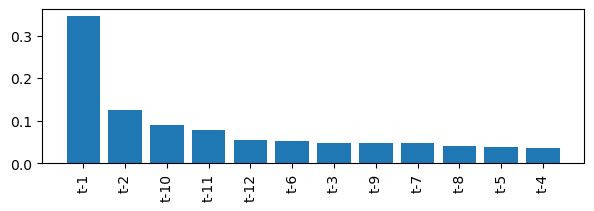

In [115]:
# Gradient Boosted Model Feature Importance
# Extract feature importances from the fitted gradient boosting model
feature_importances = gbr.feature_importances_

# Get the indices of the largest to smallest feature importances
sorted_index = np.argsort(feature_importances)[::-1]
x2 = range(X1.shape[1])

# Create tick labels 
feature_names = ['t-12', 't-11', 't-10', 't-9', 't-8', 't-7', 't-6', 't-5', 't-4', 't-3',
       't-2', 't-1']
labels = np.array(feature_names)[sorted_index]
fig, ax = plt.subplots(figsize=(7,2))
plot.bar(x2, feature_importances[sorted_index], tick_label=labels)

# Set the tick lables to be the feature names, according to the sorted feature_idx
plot.xticks(rotation=90)
plot.show()

**Note**
Notice the feature importances are not exactly the same as the random forest model's but they are close.

In [116]:
lag_regressors = ['Decision tree', 'Decision tree + optimal max_depth', 'Random Forest', 
                  'Random Forest + Grid Search','Gradient Boosted Tree' ]

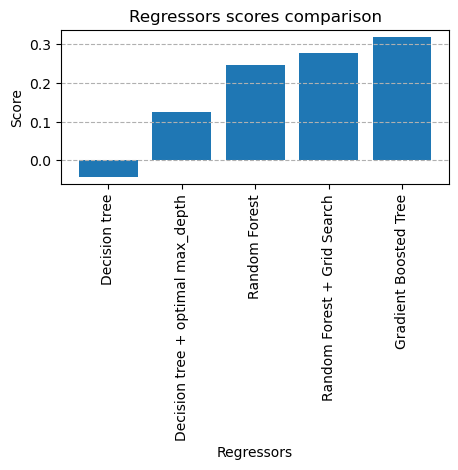

In [117]:
fig, ax = plt.subplots(figsize=(5,2))
plt.bar(range(len(lag_score)), lag_score)

# Setting the ticks on the x-axis using the string list
plt.xticks(range(len(lag_regressors)), lag_regressors, rotation = 90)
plt.grid(axis='y', linestyle = '--')
# Adding labels and title
plt.xlabel('Regressors')
plt.ylabel('Score')
plt.title('Regressors scores comparison')
# Display the plot
plt.show()

#### Summary: 
Gradient Boosted Tree model  on lags works better than any other tryed model. However, score of the prediction is still very low: 0.32. Taking in consideration all the overfitting results that we've got during other models testing we have situation when available data are not enough to build adequatly working model.

Our time series data contain yearly and monthly slice and seems like for proper prediction we need more detailed data, i.e. weekly, daily, etc..

Working with data sources that contain data for Ireland road safety, the biggest challenge is that there is not enough detailed data combined together.

<a class="anchor" id="3"></a>
# 3. Ireland road safety in comparison with other countries

[Back to Table of Contents](#0.1)

“Ireland could match the road safety record of better-performing countries” in European Union. (Eamon Ryan TD, Minister for Transport) 
    
This section will focus on comparing Ireland with other countries concerning road safety, conducted in two stages:

Firstly, we will select countries similar to Ireland based on aggregated data from Eurostat. Alongside road safety, we will consider two pivotal transportation metrics: population density and public transport accessibility. While population density is fundamental for country comparisons, 'public transport accessibility' significantly impacts road safety. Increased public transport accessibility correlates with reduced traffic volume and fewer possibilities for congestion.

We aim to statistically demonstrate that Ireland can be effectively compared with other countries regarding the two primary road safety metrics: traffic congestion and the number of injuries. This comparison will necessitate more detailed data for any of the selected countries from the initial step.


<a class="anchor" id="3.1"></a>
## 3.1  Choice of countries

[Back to Table of Contents](#0.1)

Metrics for comparison:
    
- Population Density
    
- Transport Accessibility
    
- Road Safety

    
All parameters will be compared based on most recent available data on Eurostat. 
    
    
Source: https://ec.europa.eu/eurostat/web/main/data/database

<a class="anchor" id="3.1.1"></a>
### 3.1.1 'Populatopn Density' - comparison

[Back to Table of Contents](#0.1)

In [119]:
#importing csv file with population density data
df = pd.read_csv('density.csv')
df.head()

,DATAFLOW,LAST UPDATE,freq,terrtypo,geo,TIME_PERIOD,OBS_VALUE,OBS_FLAG
0,ESTAT:URT_D3DENS(1.0),19/09/2023 23:00,A,BRD_R,AL,2021,68.0,e
1,ESTAT:URT_D3DENS(1.0),19/09/2023 23:00,A,BRD_R,AL,2022,66.0,e
2,ESTAT:URT_D3DENS(1.0),19/09/2023 23:00,A,BRD_R,AT,2018,121.0,NaN
3,ESTAT:URT_D3DENS(1.0),19/09/2023 23:00,A,BRD_R,AT,2019,122.0,NaN
4,ESTAT:URT_D3DENS(1.0),19/09/2023 23:00,A,BRD_R,AT,2020,122.0,NaN


**Note** 

Eurostat provides population density for different territorial topologies. To have more accurate data, let's perform the comparisson by taking in consideration all of the topologies. 

Full list of the available topologies:

Abbreviations for **Territorial typology**
* URB	- Predominantly urban regions
* INT	- Intermediate regions
* INT_CTC	- Intermediate regions - close to city
* INT_RMT	- Intermediate regions - remote
* RUR	- Predominantly rural regions
* RUR_CTC	- Predominantly rural regions - close to city
* RUR_RMT	- Predominantly rural regions - remote
* CST_R	- Coastal regions
* NCST_R	- Non-coastal regions
* MNT_R	- Mountain regions
* NMNT_R	- Non-mountain regions
* ISL_R	- Island regions
* NISL_R	- Non-island regions
* BRD_R	- Border regions
* NBRD_R	- Non-border regions


In [120]:
# Filter data frame by year leaving only data from 2022 
df22 = df[df['TIME_PERIOD'] == 2022]

In [121]:
countries = [] # create an empy list

for value in df['terrtypo'].unique(): # for every unique value from column terrtypo
    dfval = df22[df22['terrtypo'] == value] #filter fata frame by current value from column terrtypo
    #sort data frame by column OBS_VALUE and reset indexes in resulting data frame
    sorted_df = dfval.sort_values(by='OBS_VALUE').reset_index(drop=True) 
    #take index of cell with 'IE' value
    index_with_ie = sorted_df[sorted_df['geo'] == 'IE'].index

    # Get prev and next coutries around IE
    if not index_with_ie.empty:
        index_ie = index_with_ie[0] 

        # Retrieve values from rows with index + 1 and index - 1 in column 'geo' if indices exist
        if index_ie + 1 in sorted_df.index:
            countries.append(sorted_df.at[index_ie + 1, 'geo'])
        if index_ie - 1 in sorted_df.index:
            countries.append(sorted_df.at[index_ie - 1, 'geo'])


In [122]:
countries = list(set(countries))
countries

['PT',
 'AL',
 'CY',
 'NO',
 'IS',
 'EE',
 'HR',
 'BG',
 'MT',
 'HU',
 'SK',
 'ES',
 'LT',
 'EL',
 'RO']

<a class="anchor" id="3.1.2"></a>
### 3.1.2 'Public Transport Accessibility' - comparison

[Back to Table of Contents](#0.1)

In [123]:
#importing our data
dfa = pd.read_csv('accessibility.csv')
dfa.head()

,DATAFLOW,LAST UPDATE,freq,unit,lev_diff,deg_urb,quantile,geo,TIME_PERIOD,OBS_VALUE,OBS_FLAG
0,ESTAT:ILC_HCMP06(1.0),27/06/2023 23:00,A,PC,HIGH,DEG1,QU1,AT,2012,5.3,NaN
1,ESTAT:ILC_HCMP06(1.0),27/06/2023 23:00,A,PC,HIGH,DEG1,QU1,BE,2012,3.5,NaN
2,ESTAT:ILC_HCMP06(1.0),27/06/2023 23:00,A,PC,HIGH,DEG1,QU1,BG,2012,23.9,NaN
3,ESTAT:ILC_HCMP06(1.0),27/06/2023 23:00,A,PC,HIGH,DEG1,QU1,CH,2012,3.8,NaN
4,ESTAT:ILC_HCMP06(1.0),27/06/2023 23:00,A,PC,HIGH,DEG1,QU1,CY,2012,10.9,NaN


**Note**
Here we have number of people with different levels of transport accessibility:

* Very high
* High
* Low
* Very low

Let's make a comparison for all of the levels.

## Challenge 2

Despite the fact that last update for transport availability data was 27/06/2023, there are only data available for 2012 year. Would be great to work with more recent data, however let's work with the available data.

In [124]:
# Filter data frame by year leaving only data from 2012
df12 = dfa[(dfa['TIME_PERIOD'] == 2012)&(dfa['deg_urb'] == 'TOTAL')&(dfa['quantile'] == 'TOTAL')]
df12.describe()

,TIME_PERIOD,OBS_VALUE
count,152.0,152.000000
mean,2012.0,25.002632
std,0.0,17.729827
min,2012.0,2.200000
25%,2012.0,9.250000
50%,2012.0,19.400000
75%,2012.0,41.575000
max,2012.0,66.900000


In [125]:
countries1 = []
for value in dfa['lev_diff'].unique(): # for every unique value from column terrtypo
    dfval = df12[df12['lev_diff'] == value] #filter fata frame by current value from column terrtypo
    #sort data frame by column OBS_VALUE and reset indexes in resulting data frame
    sorted_df = dfval.sort_values(by='OBS_VALUE').reset_index(drop=True) 
    #take index of cell with 'IE' value
    index_with_ie = sorted_df[sorted_df['geo'] == 'IE'].index

    # Get prev and next coutries around IE
    if not index_with_ie.empty:
        index_ie = index_with_ie[0] 

        # Retrieve values from rows with index + 1 and index - 1 in column 'geo' if indices exist
        if index_ie + 1 in sorted_df.index:
            countries1.append(sorted_df.at[index_ie + 1, 'geo'])
        if index_ie - 1 in sorted_df.index:
            countries1.append(sorted_df.at[index_ie - 1, 'geo'])

In [126]:
countries1 = list(set(countries1))
countries1

['EA', 'DE', 'FI', 'NO', 'BE', 'DK', 'EL']

<a class="anchor" id="3.1.3"></a>
### 3.1.3 'Road Safety' - comparison

[Back to Table of Contents](#0.1)

In [127]:
dfs = pd.read_csv('safety_road.csv')
dfs.head()

,DATAFLOW,LAST UPDATE,freq,unit,sex,geo,TIME_PERIOD,OBS_VALUE,OBS_FLAG
0,ESTAT:TRAN_SF_ROADSE(1.0),20/06/2023 11:00,A,NR,F,AT,1999,320,NaN
1,ESTAT:TRAN_SF_ROADSE(1.0),20/06/2023 11:00,A,NR,F,AT,2000,246,NaN
2,ESTAT:TRAN_SF_ROADSE(1.0),20/06/2023 11:00,A,NR,F,AT,2001,251,NaN
3,ESTAT:TRAN_SF_ROADSE(1.0),20/06/2023 11:00,A,NR,F,AT,2002,276,NaN
4,ESTAT:TRAN_SF_ROADSE(1.0),20/06/2023 11:00,A,NR,F,AT,2003,251,NaN


**Note** 
In this dataset we have total number of collision as well as number of collisio per million inhabitants. Let's take both classifications for analysis.

* NR - Number
* P_MHAB - Per million inhabitants
* Sex - T (Total),
        F (Female),
        M (Male)
        
Filter 'Total' will be applied as for the 'Sex' column as our analysis is applicable for all the population.

Last updated data are available for 2021.

In [128]:
# Filter data frame by year leaving only data from 2022 
df21 = dfs[(dfs['TIME_PERIOD'] == 2021)&(dfs['sex'] == 'T')]
df21.describe()

,TIME_PERIOD,OBS_VALUE
count,62.0,62.000000
mean,2021.0,669.500000
std,0.0,2578.550525
min,2021.0,9.000000
25%,2021.0,41.000000
50%,2021.0,58.500000
75%,2021.0,280.750000
max,2021.0,19917.000000


In [129]:
countries2 = [] 

for value in dfs['unit'].unique(): # for every unique value from column terrtypo
    dfval = df21[df21['unit'] == value] #filter fata frame by current value from column terrtypo
    #sort data frame by column OBS_VALUE and reset indexes in resulting data frame
    sorted_df = dfval.sort_values(by='OBS_VALUE').reset_index(drop=True) 
    #take index of cell with 'IE' value
    index_with_ie = sorted_df[sorted_df['geo'] == 'IE'].index

    # Get prev and next coutries around IE
    if not index_with_ie.empty:
        index_ie = index_with_ie[0] 

        # Retrieve values from rows with index + 1 and index - 1 in column 'geo' if indices exist
        if index_ie + 1 in sorted_df.index:
            countries2.append(sorted_df.at[index_ie + 1, 'geo'])
        if index_ie - 1 in sorted_df.index:
            countries2.append(sorted_df.at[index_ie - 1, 'geo'])

In [130]:
countries2

['LV', 'DK', 'NL', 'IS']

**Note**

Let's now combine the obtained lists and select the countries that appear more frequently.

<a class="anchor" id="3.1.4"></a>
### 3.1.4 Selecting TOP-5 countries

[Back to Table of Contents](#0.1)

In [131]:
selected_countries = []
selected_countries.extend(countries2)
selected_countries.extend(countries1)
selected_countries.extend(countries)
frequency_counter = Counter(selected_countries)
top_5 = frequency_counter.most_common(5)
top_5

[('DK', 2), ('IS', 2), ('NO', 2), ('EL', 2), ('LV', 1)]

**Note** 
From our top 5 list of counries we can see that the most frequent countries are: Denmark, Iceland, Norway and Greece.

For the final decision let's plot our data.

<a class="anchor" id="3.1.5"></a>
### 3.1.5 Making final decision based on data visualisation

[Back to Table of Contents](#0.1)

No grids and random collor will be used in the graphs as no strict acuracy is needed for comparison to be done. 

In [132]:
df22 = df.groupby('geo')['OBS_VALUE'].sum().reset_index()
df22 = df22[(df22['geo'] == 'DK')|(df22['geo'] == 'IS')|(df22['geo'] == 'EL')|(df22['geo'] == 'NO')|(df22['geo'] == 'IE')]

df12 = dfa.groupby('geo')['OBS_VALUE'].sum().reset_index()
df12 = df12[(df12['geo'] == 'DK')|(df12['geo'] == 'IS')|(df12['geo'] == 'EL')|(df12['geo'] == 'NO')|(df12['geo'] == 'IE')]

df21 = dfs.groupby('geo')['OBS_VALUE'].sum().reset_index()
df21 = df21[(df21['geo'] == 'DK')|(df21['geo'] == 'IS')|(df21['geo'] == 'EL')|(df21['geo'] == 'NO')|(df21['geo'] == 'IE')]

In [133]:
df21

,geo,OBS_VALUE
7,DK,17076
9,EL,65748
16,IE,15909
17,IS,3986
25,NO,11644


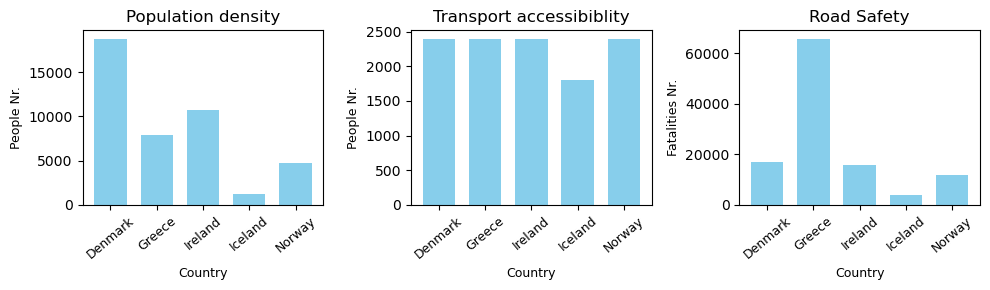

In [134]:

labels = ['Denmark', 'Greece', 'Ireland', 'Iceland','Norway']

plt.figure()
plt.subplot(1,3,1)
df22.plot(kind = 'bar', stacked = False, figsize = (10, 3), width=0.7, color='skyblue', ax = plt.gca(),legend=None)
plt.title('Population density', size = 12)
plt.xlabel('Country', size = 9)
plt.ylabel('People Nr.', size = 9)
plt.xticks(np.arange(5),labels = labels,rotation = 40, size = 9)

plt.subplot(1,3,2)
df12.plot(kind = 'bar', stacked = False, figsize = (10, 3), width=0.7, color='skyblue', ax = plt.gca(), legend=None)
plt.title('Transport accessibiblity', size = 12)
plt.xlabel('Country', size = 9)
plt.ylabel('People Nr.', size = 9)
plt.xticks(np.arange(5),labels = labels,rotation = 40, size = 9)

plt.subplot(1,3,3)
df21.plot(kind = 'bar', stacked = False, figsize = (10, 3), width=0.7, color='skyblue', ax = plt.gca(), legend=None)
plt.title('Road Safety', size = 12)
plt.xlabel('Country', size = 9)
plt.ylabel('Fatalities Nr.', size = 9)
plt.xticks(np.arange(5),labels = labels,rotation = 40, size = 9)

plt.tight_layout() 
plt.show()

**Note** 

From the visual analysis we can **exclude Iceland** from the list. As per road safety data comparison we can see that Greece has significant difference in numbers, thus we can exclude it from the comparison list.  

<a class="anchor" id="3.2"></a>
## 3.2 Processing of the data for each country

[Back to Table of Contents](#0.1)

Before applying statistical methods to compair selected countries, we will need to collect and prepare collected data.

All the data were collected from central national statistical portals and are accessible to the general public.

Data for **Ireland** was previously collected from https://data.cso.ie/ and contain the following slices:
* Fatal Collisions                     
* Injury Collisions                    
* All Fatal and Injury Collisions     
* Killed Casualties                    
* Injured Casualties                   
* All Killed and Injured Casualties

Data for **Norway** was collected from https://www.ssb.no/en/statbank/list/vtu and contain:                 
* Killed Casualties                    
* Injured Casualties                   
* All Killed and Injured Casualties

Data for **Denmark** was collected from https://www.dst.dk/en/Statistik/emner/transport and contain:                 
* All Fatal and Injury Collisions     


## Challenge 3

There is no possibility to make a comparison between all 3 countries, as different nations collect and store the data in different slices. Datasets varies based on the policies of the statistical agencies, the level of detail or granularity, and restrictions due to privacy, confidentiality, or proprietary reasons. 

Thus we can compare:

* **Collision number** for Ireland and Denmark
* **Casualty number** for Ireland and Norway.


<a class="anchor" id="3.2.1"></a>
### 3.2.1 IRELAND - data preparation

[Back to Table of Contents](#0.1)

In [137]:
#Loading already saved file into a dataframe
df_ie = pd.read_csv('safety_ie.csv')
df_ie.head()

,Statistic Label,Year,Month of Year,UNIT,VALUE
0,Fatal Collisions,2005,All months,Number,360.0
1,Fatal Collisions,2005,January,Number,31.0
2,Fatal Collisions,2005,February,Number,34.0
3,Fatal Collisions,2005,March,Number,23.0
4,Fatal Collisions,2005,April,Number,20.0


In [138]:
df_ie.describe()

,Year,VALUE
count,1326.000000,1325.000000
mean,2013.000000,711.214340
std,4.900828,1488.180577
min,2005.000000,3.000000
25%,2009.000000,23.000000
50%,2013.000000,474.000000
75%,2017.000000,639.000000
max,2021.000000,10037.000000


**Note** 

Available data period - 2005 - 2021

In [139]:
df_ie['Statistic Label'].value_counts()

Statistic Label
Fatal Collisions                     221
Injury Collisions                    221
All Fatal and Injury Collisions      221
Killed Casualties                    221
Injured Casualties                   221
All Killed and Injured Casualties    221
Name: count, dtype: int64

**Note** 

221 observation for every feature available 

In [140]:
#We count the values
value_counts = df_ie['Statistic Label'].value_counts()
relative_frequencies = value_counts / len(df_ie)

In [141]:
#We create the subtable to find the relative frequency
subtable = pd.DataFrame({'Statistic Label': value_counts.index, 
                         'Frequency': value_counts.values, 
                         'Relative Frequency': relative_frequencies.values})
subtable

,Statistic Label,Frequency,Relative Frequency
0,Fatal Collisions,221,0.166667
1,Injury Collisions,221,0.166667
2,All Fatal and Injury Collisions,221,0.166667
3,Killed Casualties,221,0.166667
4,Injured Casualties,221,0.166667
5,All Killed and Injured Casualties,221,0.166667


**Note**

For more comfortable future comparisson with other countries, let's insert country name and make name for column with month shorter.

In [142]:
# renaming column 'Month of Year' in 'Month' for comfortable future usage
df_ie.rename(columns={'Month of Year':'Month'}, inplace=True) 

#Inserting additional column with 'Ireland' value for all rows
df_ie.insert(3, 'Country', 'Ireland')

In [143]:
df_ie.head()

,Statistic Label,Year,Month,Country,UNIT,VALUE
0,Fatal Collisions,2005,All months,Ireland,Number,360.0
1,Fatal Collisions,2005,January,Ireland,Number,31.0
2,Fatal Collisions,2005,February,Ireland,Number,34.0
3,Fatal Collisions,2005,March,Ireland,Number,23.0
4,Fatal Collisions,2005,April,Ireland,Number,20.0


**Note**

To explore available trends let's expand data from rows to columns.

In [144]:
df1 = df_ie.drop(df_ie[(df_ie["Statistic Label"] != "All Fatal and Injury Collisions")].index)
final_ie = df1[['Year', 'Month','Country']]

for label in df_ie['Statistic Label'].unique():
    df1 = df_ie.drop(df_ie[(df_ie["Statistic Label"] != label)].index)
    df1.rename(columns={'VALUE': label}, inplace=True)
    dff = df1[['Year', 'Month','Country', label]]
    final_ie = pd.merge(final_ie,dff)
final_ie.head()

,Year,Month,Country,Fatal Collisions,Injury Collisions,All Fatal and Injury Collisions,Killed Casualties,Injured Casualties,All Killed and Injured Casualties
0,2005,All months,Ireland,360.0,6173.0,6533.0,396.0,9318.0,9714.0
1,2005,January,Ireland,31.0,442.0,473.0,33.0,683.0,716.0
2,2005,February,Ireland,34.0,427.0,461.0,37.0,591.0,628.0
3,2005,March,Ireland,23.0,475.0,498.0,26.0,718.0,744.0
4,2005,April,Ireland,20.0,509.0,529.0,23.0,726.0,749.0


In [145]:
final_ie['Month'].unique()

array(['All months', 'January', 'February', 'March', 'April', 'May',
       'June', 'July', 'August', 'September', 'October', 'November',
       'December'], dtype=object)

In [146]:
#dropping 'All month' value in favor to data omogenity
final_ie = final_ie.drop(final_ie[(final_ie["Month"] == 'All months')].index)

In [147]:
final_ie.describe()

,Year,Fatal Collisions,Injury Collisions,All Fatal and Injury Collisions,Killed Casualties,Injured Casualties,All Killed and Injured Casualties
count,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,203.000000
mean,2013.000000,16.274510,463.196078,479.470588,17.754902,658.406863,676.354680
std,4.911031,7.192849,71.919638,74.326030,8.127599,119.661205,123.936235
min,2005.000000,3.000000,132.000000,139.000000,3.000000,159.000000,166.000000
25%,2009.000000,11.000000,426.750000,445.000000,12.000000,596.750000,612.000000
50%,2013.000000,15.000000,468.500000,484.500000,16.000000,661.000000,680.000000
75%,2017.000000,19.000000,509.000000,527.500000,21.000000,725.250000,743.500000
max,2021.000000,38.000000,611.000000,628.000000,44.000000,976.000000,995.000000


**Note**

We have 1 missing value for 'All Killed and Injured Casualties'. In order to have equal number of the rows for all created datasets we can't drop it, so let's fill it with the mean value.

In [148]:
final_ie['All Killed and Injured Casualties'] = final_ie['All Killed and Injured Casualties'].fillna(
    final_ie['All Killed and Injured Casualties'].mean())

<a class="anchor" id="3.2.2"></a>
### 3.2.2 Norway - data preparation

[Back to Table of Contents](#0.1)

In [149]:
#loading file saved from official statistic website for Norway 
df_no = pd.read_csv('safety_no.csv')
df_no.head()

,Year,Killed,All injured
0,2005M01,19,830
1,2005M02,13,755
2,2005M03,17,727
3,2005M04,16,745
4,2005M05,13,1048


In [150]:
#renaming columns to have consistensy in columns name for uture data frame
df_no.rename(columns={'All injured': 'Injured Casualties',
                     'Killed': 'Killed Casualties'}, inplace=True)

In [151]:
# #taking only numeric columns
final_no = df_no

final_no['All Killed and Injured Casualties'] = final_no['Killed Casualties'] + final_no['Injured Casualties']

#adding labels and transforming dates
final_no[['Year', 'Month']] = df_no['Year'].str.split('M', expand=True)
final_no.insert(3, 'Country', 'Norway')

In [152]:
final_no.head()

,Year,Killed Casualties,Injured Casualties,Country,All Killed and Injured Casualties,Month
0,2005,19,830,Norway,849,01
1,2005,13,755,Norway,768,02
2,2005,17,727,Norway,744,03
3,2005,16,745,Norway,761,04
4,2005,13,1048,Norway,1061,05


In [153]:
#Create month mapping in order to have unified names
month_mapping = {
    'Jan': 'January',
    '01': 'January',
    'Feb': 'February',
    '02': 'February',
    'Mar': 'March',
    '03': 'March',
    'Apr': 'April',
    '04': 'April',
    'May': 'May',
    '05': 'May',
    'Jun': 'June',
    '06': 'June',
    'Jul': 'July',
    '07': 'July',
    'Aug': 'August',
    '08': 'August',
    'Sep': 'September',
    '09': 'September',
    'Oct': 'October',
    '10': 'October',
    'Nov': 'November',
    '11': 'November',
    'Dec': 'December',
    '12': 'December'
}

In [154]:
# Replace short month names with full month names using the mapping
final_no['Month'] = final_no['Month'].map(month_mapping)
final_no['Year'] = final_no['Year'].astype(int)
final_no.head()

,Year,Killed Casualties,Injured Casualties,Country,All Killed and Injured Casualties,Month
0,2005,19,830,Norway,849,January
1,2005,13,755,Norway,768,February
2,2005,17,727,Norway,744,March
3,2005,16,745,Norway,761,April
4,2005,13,1048,Norway,1061,May


In [155]:
final_no.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 6 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   Year                               204 non-null    int32 
 1   Killed Casualties                  204 non-null    int64 
 2   Injured Casualties                 204 non-null    int64 
 3   Country                            204 non-null    object
 4   All Killed and Injured Casualties  204 non-null    int64 
 5   Month                              204 non-null    object
dtypes: int32(1), int64(3), object(2)
memory usage: 8.9+ KB


<a class="anchor" id="3.2.3"></a>
### 3.2.3 Denmark - data preparation

[Back to Table of Contents](#0.1)

In [156]:
#Loading saved file with data for Denmark inro dataframe
df_dk = pd.read_csv('safety_dk.csv')
df_dk.head()

,Year,Month,All Fatal and Injury Collisions
0,2004,January,476
1,2004,February,456
2,2004,March,421
3,2004,April,488
4,2004,May,522


In [157]:
#labeling data
df_dk.insert(3, 'Country', 'Denmark')

In [158]:
#filtering excesive data to have consistency in the time period
final_dk = df_dk.drop(df_dk[(df_dk["Year"] == 2004)| (df_dk["Year"] == 2022)].index)

In [159]:
#validating the result
final_dk.info()

<class 'pandas.core.frame.DataFrame'>
Index: 204 entries, 12 to 215
Data columns (total 4 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   Year                             204 non-null    int64 
 1   Month                            204 non-null    object
 2   All Fatal and Injury Collisions  204 non-null    int64 
 3   Country                          204 non-null    object
dtypes: int64(2), object(2)
memory usage: 8.0+ KB


<a class="anchor" id="3.3"></a>
## 3.3 Comparison of countries

[Back to Table of Contents](#0.1)

Following metrics will be compared: 

* **Collision number** for Ireland and Denmark
* **Casualty number** for Ireland and Norway.

One of the most common techniques used in Inferential Statistics isAnalysis of Variance, known as ANOVA. It is particularly suitable for situations involving an experiment in which a certain treatment is applied (x) to subjects and the response is measured afterwards (y). ANOVA test will evaluate the variation between the mean of different variables. In other words, ANOVA is a parametric test and it is used to compare the means of three or more samples.

Before setting up the hypothesis we will need to check the ANOVA conditions, using the data collected from each of the coutries (k populations).

For this following checks must be performed: 
1. The k populations are independent. In other words, their outcomes do not affect each other.
    * ***We already have this step done as our data belong to different countries and does not depend on each other***
2. The k populations have a normal distribution.
    * ***Two types of check will be done: cisualisation of the data + Shapiro Wilk test, to make sure that data are normally distributed***
3. The variances of the k normal distributions are equal.
    * ***Conduct an F-test on the data to make sure that the variances are equal***

<a class="anchor" id="3.3.1"></a>
### 3.3.1 Collisions Number comparisson

[Back to Table of Contents](#0.1)



In [160]:
# Creating 1 data frame with data from all countries
ie = final_ie[['Country','Year','Month','All Fatal and Injury Collisions']]
dk = final_dk[['Country','Year','Month','All Fatal and Injury Collisions']]
df = pd.concat([ie,dk])

In [161]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 408 entries, 1 to 215
Data columns (total 4 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          408 non-null    object 
 1   Year                             408 non-null    int64  
 2   Month                            408 non-null    object 
 3   All Fatal and Injury Collisions  408 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 15.9+ KB


**Now we will test the assumptions for ANOVA**

We will use QQ-plot to visualize if data is normally distributed or not.


**QQ plot:**

QQ plot is a visualization test to see if the data comes from normal distribution or not. On x-axis, theoratical quantiles are plotted, which assumes that data has mean of 0 and standard deviation of 1 and on y-axis there is actual plot of data. If actual data follows a normal distribution then plot will show dots (original data) tightly coupled around the straight line.

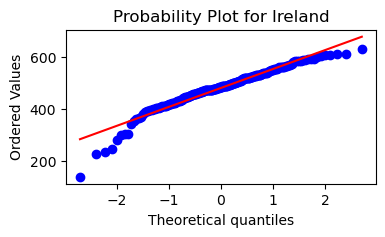

In [163]:
plt.figure(figsize=(4, 2))
stats.probplot(ie['All Fatal and Injury Collisions'], plot = plt)
plt.title("Probability Plot for Ireland")
plt.show()

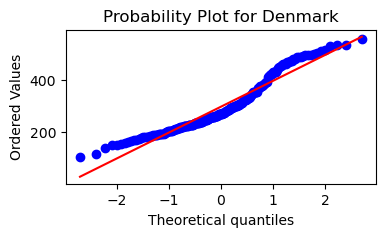

In [164]:
plt.figure(figsize=(4, 2))
stats.probplot(dk['All Fatal and Injury Collisions'], plot = plt)
plt.title("Probability Plot for Denmark")
plt.show()

**Shapiro Wilk Test**

From our plots seems like both data sets are close to normality. 

Let's perform Shapiro test  and check the p-value. In case it's less than our alpha, we reject our null hypotesis and assume that data are normaly distributed.

##### H0: data comes from a normal distribution 
##### H1: data does not come from a normal distribution

In [165]:
#Shapiro test Ireland
stats.shapiro(df['All Fatal and Injury Collisions'][df.Country=="Ireland"])

ShapiroResult(statistic=0.9408243298530579, pvalue=2.142132871085778e-07)

In [166]:
#Shapiro test Denmark
stats.shapiro(df['All Fatal and Injury Collisions'][df.Country=="Denmark"])

ShapiroResult(statistic=0.9341702461242676, pvalue=5.74906167116751e-08)

**Shapiro test interpretation**

For both data sets (Ireland and Denmark) we have p-value less than alpha, so we reject our null hypotesis. 

At this point we can't continue with the ANOVA as our data are not normally distributed. So it will be reasonable to use non-parametric tests for our data.

#### Non-parametric tests

The most appropriate and common test that we can use is a **U-Mann Whitman**. This is the non-parametric version of ANOVA. We do not have to assume homogeneity and normal distribution for the original variable.

We will perform the comparison between Ireland and Denmark for number of collisions.


##### H0: there is no difference in the average collision number for Ireland and Denmark.
##### H1: there is a different collision number

In [167]:
#we create the objects per coutry

IE = df['All Fatal and Injury Collisions'][df.Country=="Ireland"]
DK = df['All Fatal and Injury Collisions'][df.Country=="Denmark"]

In [168]:
stat, p = mannwhitneyu(IE, DK)
print('Statistical Test:', stat)
print("p-value:", p)

Statistical Test: 37560.0
p-value: 6.179554831468535e-45


**Interpretation**

From our U-test we can see that p-value is significantly lower than alpha, so we reject our null hypotesis, i.e. Number of collisions are significantly different in Ireland and Denmark.

Additionally, we can perform same U-test for the last year of available data - 2021

In [169]:
#we create the objects per coutry

IE = df['All Fatal and Injury Collisions'][(df.Country=="Ireland")&(df.Year==2021)]
DK = df['All Fatal and Injury Collisions'][(df.Country=="Denmark")&(df.Year==2021)]

In [170]:
stat, p = mannwhitneyu(IE, DK)
print('Statistical Test:', stat)
print("p-value:", p)

Statistical Test: 138.0
p-value: 0.00015579589308788297


**Summary** 

From our U-tests we can conclude that Ireland has different average number of road accidents in comparison with Denmark for the whole period of time (2005-2021) as well as for only 2021 

<a class="anchor" id="3.3.2"></a>
### 3.3.2 Casualties Number comparisson

[Back to Table of Contents](#0.1)

In [171]:
# Creating 1 data frame with data from all countries
ie1 = final_ie[['Country','Year','Month','All Killed and Injured Casualties', 'Killed Casualties','Injured Casualties']]
no1 = final_no[['Country','Year','Month','All Killed and Injured Casualties','Killed Casualties','Injured Casualties']]

df1 = pd.concat([ie1,no1])

In [172]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 408 entries, 1 to 203
Data columns (total 6 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Country                            408 non-null    object 
 1   Year                               408 non-null    int64  
 2   Month                              408 non-null    object 
 3   All Killed and Injured Casualties  408 non-null    float64
 4   Killed Casualties                  408 non-null    float64
 5   Injured Casualties                 408 non-null    float64
dtypes: float64(3), int64(1), object(2)
memory usage: 22.3+ KB


**QQ plot** 

Checking normal distribution of the data using visualisation

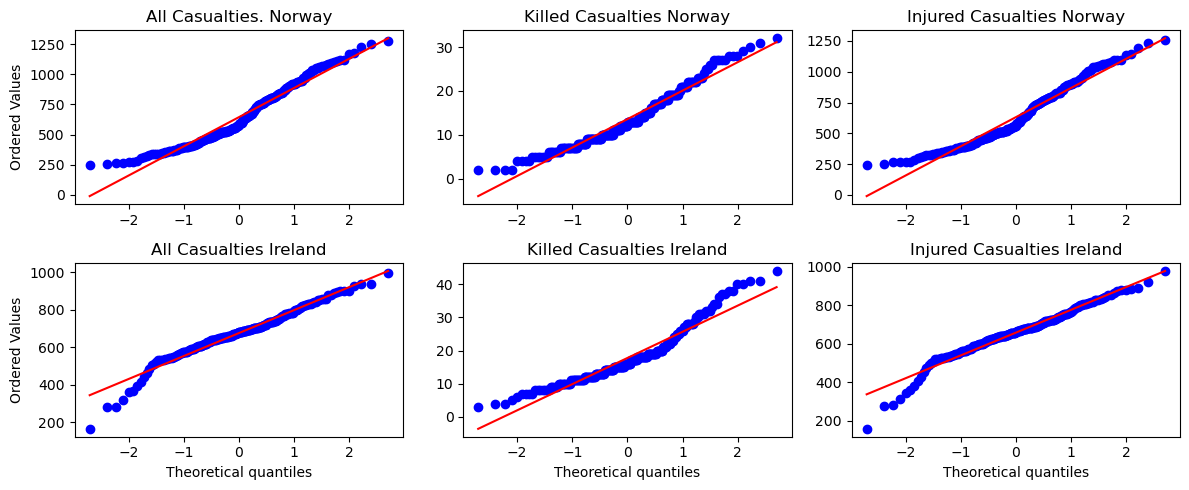

In [173]:
# Create the subplots
fig, axes = plt.subplots(2, 3, figsize=(12, 5))

# Plot probability plots for Norway data
stats.probplot(no1['All Killed and Injured Casualties'], plot = axes[0, 0])
axes[0, 0].set_title('All Casualties. Norway')
axes[0, 0].set_xlabel('')

stats.probplot(no1['Killed Casualties'], plot = axes[0, 1])
axes[0, 1].set_title('Killed Casualties Norway')
axes[0, 1].set_xlabel('')
axes[0, 1].set_ylabel('')

stats.probplot(no1['Injured Casualties'], plot = axes[0, 2])
axes[0, 2].set_title('Injured Casualties Norway')
axes[0, 2].set_xlabel('')
axes[0, 2].set_ylabel('')

# Plot probability plots for Ireland data
stats.probplot(ie1['All Killed and Injured Casualties'], plot = axes[1, 0])
axes[1, 0].set_title('All Casualties Ireland')

stats.probplot(ie1['Killed Casualties'], plot = axes[1, 1])
axes[1, 1].set_title('Killed Casualties Ireland')
axes[1, 1].set_ylabel('')

stats.probplot(ie1['Injured Casualties'], plot = axes[1, 2])
axes[1, 2].set_title('Injured Casualties Ireland')
axes[1, 2].set_ylabel('')
# Tight layout
plt.tight_layout()

# Show the plot
plt.show()

From our plots seems like we have same situation: Ireland and Norway data are very close to normality. 

**Shapiro test**

Setting our hypotesis for the normal distribution for our data:

##### H0: data comes from a normal distribution 
##### H1: data does not come from a normal distribution


In [174]:
labels = ['All Casualties for 2005 - 2021', 'Killed Casualties for 2005 - 2021', 'Injured Casualties for 2005 - 2021', 
          'All Casualties for 2021', 'Killed Casualties for 2021', 'Injured Casualties for 2021']
p_value = []

In [175]:
#Shapiro test Ireland
statistic, pvalue =  stats.shapiro(df1['All Killed and Injured Casualties'][df1.Country=="Ireland"])
p_value.append(round(pvalue,3))
statistic, pvalue =  stats.shapiro(df1['Killed Casualties'][df1.Country=="Ireland"])
p_value.append(round(pvalue,3))
statistic, pvalue =  stats.shapiro(df1['Injured Casualties'][df1.Country=="Ireland"])
p_value.append(round(pvalue,3))

In [176]:
#Shapiro test Norway
statistic, pvalue = stats.shapiro(df1['All Killed and Injured Casualties'][df1.Country=="Norway"])
p_value.append(round(pvalue,3))
statistic, pvalue = stats.shapiro(df1['Killed Casualties'][df1.Country=="Norway"])
p_value.append(round(pvalue,3))
statistic, pvalue = stats.shapiro(df1['Injured Casualties'][df1.Country=="Norway"])
p_value.append(round(pvalue,3))

In [177]:
#creating data frame with test results for every tested period
scores = pd.DataFrame(list(zip(labels, p_value)), columns=['Labels', 'Shapiro-test'])
scores

,Labels,Shapiro-test
0,All Casualties for 2005 - 2021,0.0
1,Killed Casualties for 2005 - 2021,0.0
2,Injured Casualties for 2005 - 2021,0.0
3,All Casualties for 2021,0.0
4,Killed Casualties for 2021,0.0
5,Injured Casualties for 2021,0.0


**Shapiro test interpretation**

We have same situation here: for two sets of data we have p-value less than alpha (IE and NO), so we reject our null hypotesis.
***

Using same strtegy for casualties comparison, i.e. applying non-parametric **U-Mann Whitman** test for the whole period.

In [179]:
#we create the objects for testing

IE_all = df1['All Killed and Injured Casualties'][df1.Country=="Ireland"]
NO_all = df1['All Killed and Injured Casualties'][df1.Country=="Norway"]

IE_kil = df1['Killed Casualties'][df1.Country=="Ireland"]
NO_kil = df1['Killed Casualties'][df1.Country=="Norway"]

IE_inj = df1['Injured Casualties'][df1.Country=="Ireland"]
NO_inj = df1['Injured Casualties'][df1.Country=="Norway"]

p_values = []

In [180]:
#Run tests for each pair of the testing objects and saving the results in the list
stat, p = mannwhitneyu(IE_all, IE_all)
p_values.append(round(p,3))

stat, p = mannwhitneyu(IE_kil, NO_kil)
p_values.append(round(p,3))

stat, p = mannwhitneyu(IE_inj, NO_inj)
p_values.append(round(p,3))

***
* Performing same test for 2021

In [223]:
#we create the objects for testing

IE_all = df1['All Killed and Injured Casualties'][(df1.Country=="Ireland")&(df1.Year==2021)]
NO_all = df1['All Killed and Injured Casualties'][(df1.Country=="Norway")&(df1.Year==2021)]

IE_kil = df1['Killed Casualties'][(df1.Country=="Ireland")&(df1.Year==2021)]
NO_kil = df1['Killed Casualties'][(df1.Country=="Norway")&(df1.Year==2021)]

IE_inj = df1['Injured Casualties'][(df1.Country=="Ireland")&(df1.Year==2021)]
NO_inj = df1['Injured Casualties'][(df1.Country=="Norway")&(df1.Year==2021)]

In [181]:
#Run tests for each pair of the testing objects and updating the list with results

stat, p = mannwhitneyu(IE_all, IE_all)
p_values.append(round(p,3))

stat, p = mannwhitneyu(IE_kil, NO_kil)
p_values.append(round(p,3))

stat, p = mannwhitneyu(IE_inj, NO_inj)
p_values.append(round(p,3))

In [182]:
#updating the dataframe with results from U-Mann Whitman test
scores['U-Mann Whitman'] = p_values
scores

,Labels,Shapiro-test,U-Mann Whitman
0,All Casualties for 2005 - 2021,0.0,1.000
1,Killed Casualties for 2005 - 2021,0.0,0.000
2,Injured Casualties for 2005 - 2021,0.0,0.008
3,All Casualties for 2021,0.0,1.000
4,Killed Casualties for 2021,0.0,0.000
5,Injured Casualties for 2021,0.0,0.008


**Summary** 

•	the average number of all casualties for Ireland and Norway is the same for the whole period as well as for 2021,

•	the average number of fatalities for 2021 also can be compared between 2 countries,

•	the average number of fatalities for the whole period is different as well as the average number of Injured Casualties for both tested periods

<a class="anchor" id="4"></a>
# 4. Ireland road Safety sentiment analysis

[Back to Table of Contents](#0.1)

This section contains the public sentiment analysis of 'Road Safety' in Ireland using the dataset obtained via the Reddit API.



<a class="anchor" id="4.1"></a>
## 4.1. Sentimental Analysis for Reddit comments

[Back to Table of Contents](#0.1)

Reddit is a widely used social network in Ireland, where people engage in discussions on a diverse range of popular topics across various communities.

Using reddit official documentation for Python Reddit API Wrapper and some YouTube tutorials I've created an API in my Reddit account. After this I was able to extract comments based on the specific query criteria: Subreddit 'Ireland' and comments with the words 'road safety' to ensure that the results are relevant.

References:
* https://praw.readthedocs.io/en/latest/tutorials/comments.html

Tutorials used:
* https://www.youtube.com/watch?v=Y7BSe7EiBTs
* https://www.youtube.com/watch?v=FdjVoOf9HN4

<a class="anchor" id="4.1.1"></a>
### 4.1.1. Data collection for 'Road Safety' sentiment analysis

[Back to Table of Contents](#0.1)

**IMPORTANT NOTE**

The data collection phase will not work on your device as it requires a personal API key.

In [183]:
#reading personal secret token from the file
with open ('st.txt','r') as f:
    st = f.read()

In [184]:
#assigning personal API ID and Token to variables 
CLIENT_ID = 'LchMksVUmRUeyg'
SECRET_TOKEN = st

In [185]:
#Installing praw library
#!pip install praw

In [239]:
# Log In to App: 
reddit = praw.Reddit(client_id=CLIENT_ID, 
                     client_secret=SECRET_TOKEN, 
                     user_agent='Data Scraping')
reddit

In [240]:
# Create a list to store data
headlines = []

# Search for the query in posts with specific words 'road safety'
for submission in reddit.subreddit('Ireland').search('road safety', sort = 'all', limit = None):
    headlines.append([submission.id])
columns = ['ID']    
df = pd.DataFrame(headlines, columns = columns)
df.head()

,ID
0,ydudkc
1,n1u1by
2,z9j82g
3,atieu4
4,13o2ia0


In [241]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      180 non-null    object
dtypes: object(1)
memory usage: 1.5+ KB


In [242]:
# Initialize an empty list to store comment bodies
comments_list = []

# Assuming 'df' contains a column 'ID' with submission IDs
for value in df['ID']:
    submission = reddit.submission(value)
    # Assuming 'submission.comments' contains the comments data
    for comment in submission.comments:
        if isinstance(comment, praw.models.MoreComments):
            continue  # Skip 'MoreComments' objects
        else:
            comments_list.append(comment.body)

# Create a DataFrame from the comments list (outside the loop)
df_comments = pd.DataFrame({'Comment': comments_list})
df_comments.head()

,Comment
0,Don't know about the rest of the offences but ...
1,€160 (was €80)\n\n- Speeding \n- Unaccompanied...
2,Thanks for the heads up. Going to get in some ...
3,Using a phone should be triple the fine.
4,Am I alone in having no issue with this?


In [243]:
df_comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2868 entries, 0 to 2867
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Comment  2868 non-null   object
dtypes: object(1)
memory usage: 22.5+ KB


In [244]:
df_comments.to_csv('reddit_com.csv', index = False)

<a class="anchor" id="4.1.2"></a>
### 4.1.2. Data Preparation

[Back to Table of Contents](#0.1)


Libraries used:

* https://www.nltk.org/howto/stem.html
* https://www.nltk.org/api/nltk.sentiment.vader.html
* https://www.nltk.org/search.html?q=stopwords
* https://docs.python.org/3/library/string.html
* https://docs.python.org/3/library/re.html

**Note** 

I have 2868 Reddit comments in my dataset, which I consider to be a sufficient quantity of data for initiating the analysis of public sentiment.

For this analysis the Natural Language Toolkit (NLTK) Python library will be used, as it has many features useful for this task including sentiment analysis tools.

In [187]:
df = pd.read_csv('reddit_com.csv')

In [188]:
df.head(5)

,Comment
0,Don't know about the rest of the offences but ...
1,€160 (was €80)\n\n- Speeding \n- Unaccompanied...
2,Thanks for the heads up. Going to get in some ...
3,Using a phone should be triple the fine.
4,Am I alone in having no issue with this?


In [189]:
df.shape

(2868, 1)

In [190]:
# Create a variable to store the comments as text
X = df['Comment']

# Check the result
X.head()

0    Don't know about the rest of the offences but ...
1    €160 (was €80)\n\n- Speeding \n- Unaccompanied...
2    Thanks for the heads up. Going to get in some ...
3             Using a phone should be triple the fine.
4             Am I alone in having no issue with this?
Name: Comment, dtype: object

In [191]:
# Create an instance of SentimentIntensityAnalyzer
sentiment_analyser = SentimentIntensityAnalyzer()

In [192]:
# Store the stopwords into the object named as "stop_words"
stop_words = stopwords.words('english')

# Store the string.punctuation into an object punct
punct = string.punctuation

# Initialise an object using a method PorterStemmer
stemmer = PorterStemmer()

These steps aimed to enhance the model's accuracy by removing less meaningful words, eliminating punctuation, and reducing words to their base forms through stemming.

In [193]:
# Create an empty list to store the data
data=[]

# Create a for loop to clean available text comments & store them in a created list 'data'
for i in range(len(X)):
    #removing everything that is not in the range of 'a-z' or 'A-Z'
    red_com = re.sub('[^a-zA-Z]', ' ', X.iloc[i]) 
    #Converting the text to lowercase. 
    red_com = red_com.lower().split() 
    #use a stemmer for reducing words to their base or root form by removing suffixes
    red_com = [stemmer.stem(word) for word in red_com if (word not in stop_words) and (word not in punct)]
    red_com = ' '.join(red_com)
    #store and update the result in the data
    data.append(red_com)

In [194]:
#Checking the created list
data[:5]

['know rest offenc phone usag drive rampant',
 'speed unaccompani learner wear seat belt show l n plate use mobil phone child improperli restrain new offenc misus disabl park permit illeg park electr charg bay hgv enter specifi public road without valid permit',
 'thank head go get qualiti speed even save fortun',
 'use phone tripl fine',
 'alon issu']

In [195]:
# Create a function to get scores for sentiments
def get_sentiment_score(text):
    analyzer = SentimentIntensityAnalyzer()
    sentiment_score = analyzer.polarity_scores(text)['compound']
    return sentiment_score

**IMPORTANT NOTE**

Next cell needs some time to be executed

In [196]:
# Apply the function to each element from the list
sentiment_scores = list(map(get_sentiment_score, data))
# Checking the result
sentiment_scores[:10]

[0.0, 0.0, 0.6908, 0.2023, 0.0, -0.0258, 0.0, -0.2732, -0.5859, -0.7939]

**Note**

**SentimentIntensityAnalyzer** was used on pre-trained Vader to assign the sentiment scores for each comment. This was done to obtain a compound score and store it in the list. 

In [197]:
# store the result in the data frame "sentiment"
sentiment = pd.DataFrame({'Text': data, 'Score': sentiment_scores})

sentiment.head()

,Text,Score
0,know rest offenc phone usag drive rampant,0.0000
1,speed unaccompani learner wear seat belt show ...,0.0000
2,thank head go get qualiti speed even save fortun,0.6908
3,use phone tripl fine,0.2023
4,alon issu,0.0000


<a class="anchor" id="4.1.3"></a>
### 4.1.3 Mapping the compound scores

[Back to Table of Contents](#0.1)

In [198]:
# Create a function to map the compound scores to a particular polarity classification
def format_output(compound_score):
    polarity = "neutral"
    if compound_score >= 0.05:
        polarity = "positive"
    elif compound_score <= -0.05:
        polarity = "negative"
    return polarity

In [199]:
# Create a new column 'Polarity' using the format_output function
sentiment['Polarity'] = sentiment['Score'].apply(format_output)

# Validate results
sentiment.head()

,Text,Score,Polarity
0,know rest offenc phone usag drive rampant,0.0000,neutral
1,speed unaccompani learner wear seat belt show ...,0.0000,neutral
2,thank head go get qualiti speed even save fortun,0.6908,positive
3,use phone tripl fine,0.2023,positive
4,alon issu,0.0000,neutral


In [200]:
sentiment['Score'][:5]

0    0.0000
1    0.0000
2    0.6908
3    0.2023
4    0.0000
Name: Score, dtype: float64

<a class="anchor" id="4.1.4"></a>
### 4.1.4 Displaying result of sentiment analysis

[Back to Table of Contents](#0.1)

In [201]:
# Group by the 'polarity' column and count the number of rows for each category
pol = sentiment.groupby('Polarity').count()

# Validate results
pol.head()

,Text,Score
Polarity,,
negative,1015,1015
neutral,847,847
positive,1006,1006


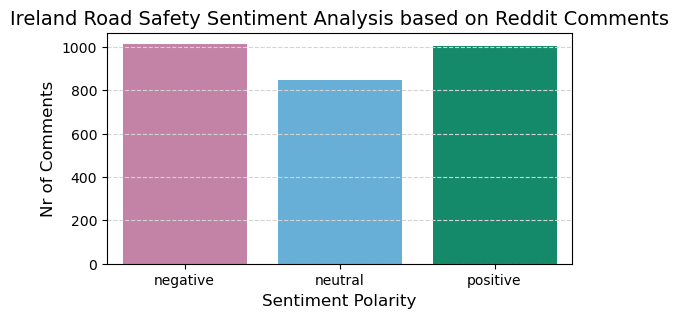

In [202]:
# Define custom colors for each sentiment
colors = {'negative': '#CC79A7', 'neutral': '#56B4E9', 'positive': '#009E73'}

# Plot the monthly average passengers totals using a bar chart
plt.figure(figsize = (6, 3))
sns.barplot(data = pol, x = pol.index, y = 'Score', palette = colors)
plt.xlabel('Sentiment Polarity', size = 12)
plt.ylabel('Nr of Comments', size = 12)
plt.title('Ireland Road Safety Sentiment Analysis based on Reddit Comments', size = 14)
plt.grid(axis = 'y', color='lightgrey', linestyle='--', linewidth = 0.8)
plt.show()

**Note**

The sentiment analysis data was transformed and presented visually to assess the overall public opinion of road safety in Ireland. The color-coded bar chart intuitively conveys the sentiment polarity, indicating slight negative bias.

<a class="anchor" id="4.2"></a>
## 4.2 Bag of Words Vectorization

[Back to Table of Contents](#0.1)


In the previous approaches, we relied on pre-built libraries for sentiment analysis. Now, we'll delve into a more customized approach involving model training. The Bag of Words Vectorization method for sentiment analysis involves three steps:

1. Pre-processing the training data: This includes normalizing text, tokenizing it into individual words, removing stop words (common words like "the," "a," "an"), and applying stemming or lemmatization to reduce words to their root forms.

2. Creating a Bag of Words: This involves representing the pre-processed text data as a numerical representation using either Count Vectorization or TF-IDF Vectorization.

3. Training a classification model: The numerical representation generated in step 2 is then fed into a suitable classification model, such as Multinomial Naive Bayes, to learn to classify sentiment.

Code for Sentiment Analysis using Bag of Words Vectorization:

* To build a sentiment analysis model using the BOW Vectorization Approach, we need a labeled dataset. Here, we'll simply use scikit-learn's CountVectorizer to create the BOW representation. Then, we train a Multinomial Naive Bayes classifier.

In [203]:
sentiment.head()

,Text,Score,Polarity
0,know rest offenc phone usag drive rampant,0.0000,neutral
1,speed unaccompani learner wear seat belt show ...,0.0000,neutral
2,thank head go get qualiti speed even save fortun,0.6908,positive
3,use phone tripl fine,0.2023,positive
4,alon issu,0.0000,neutral


In [204]:
# Pre-Prcoessing and Bag of Word Vectorization using Count Vectorizer
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv    = CountVectorizer(stop_words = 'english',ngram_range = (1, 1),tokenizer = token.tokenize)
text_counts = cv.fit_transform(sentiment['Text'])

text_counts

<2868x6357 sparse matrix of type '<class 'numpy.int64'>'
	with 45129 stored elements in Compressed Sparse Row format>

In [205]:
#Splitting the data into trainig and testing
X_train, X_test, Y_train, Y_test = train_test_split(text_counts, sentiment['Polarity'], test_size=0.25, random_state=5)

In [206]:
text_counts.shape, X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((2868, 6357), (2151, 6357), (717, 6357), (2151,), (717,))

In [207]:
# Training the model
MNB = MultinomialNB()
MNB.fit(X_train, Y_train)

# Caluclating the accuracy score of the model
predicted = MNB.predict(X_test)
accuracy_score = metrics.accuracy_score(predicted, Y_test)
print("Accuracuy Score: ",accuracy_score)

Accuracuy Score:  0.6150627615062761


**Note**

The low accuracy of 62% indicates that the model is unlikely to provide accurate predictions.

<a class="anchor" id="4.3"></a>
## 4.3 Word Cloud

[Back to Table of Contents](#0.1)

In [208]:
#!pip install wordcloud

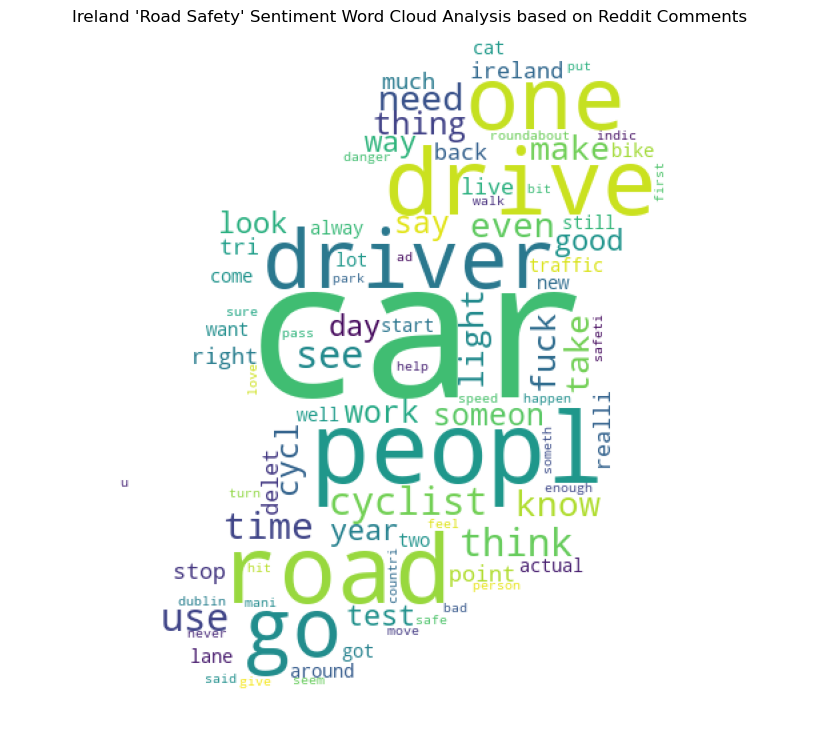

In [209]:
# Combine all the cleaned text into a single string
text = ' '.join(sentiment['Text'].dropna())

response = requests.get("https://i.pngimg.me/thumb/f/720/6208652289507328.jpg")
mask = np.array(Image.open(BytesIO(response.content)))

# Create a word cloud for visualisation
wordcloud = WordCloud(width = 400, height = 300, 
                background_color = 'white', 
                min_font_size = 10, max_font_size = 1000,
                     max_words = 300, mask = mask).generate(text)

# Plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.title("Ireland 'Road Safety' Sentiment Word Cloud Analysis based on Reddit Comments")
plt.tight_layout(pad = 0) 

# Show the plot
plt.show()

**Note**

Word cloud complements bar chart, which is believed to be more effective. Word cloud doesn't provide much insight into sentiment, but it helps understand key terms in data set, which is useful for EDA and comparison purposes.

* https://pypi.org/project/wordcloud/
* https://python-charts.com/ranking/wordcloud-matplotlib/


###  Building the ARIMA Model 



- An ARIMA model is one where the time series was differenced at least once to make it stationary and we combine the AR and the MA terms. So the equation of an ARIMA model becomes :

![ARIMA Model](https://www.machinelearningplus.com/wp-content/uploads/2019/02/Equation-4-min-865x77.png?ezimgfmt=ng:webp/ngcb1)

image source : https://www.machinelearningplus.com/wp-content/uploads/2019/02/Equation-4-min-865x77.png?ezimgfmt=ng:webp/ngcb1


##### ARIMA model in words**

Predicted Yt = Constant + Linear combination Lags of Y (upto p lags) + Linear Combination of Lagged forecast errors (upto q lags)

- **AR(p) Autoregression** – a regression model that utilizes the dependent relationship between a current observation and observations over a previous period. An auto regressive (AR(p)) component refers to the use of past values in the regression equation for the time series.


- **I(d) Integration** – uses differencing of observations (subtracting an observation from observation at the previous time step) in order to make the time series stationary. Differencing involves the subtraction of the current values of a series with its previous values d number of times.


- **MA(q) Moving Average** – a model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations. A moving average component depicts the error of the model as a combination of previous error terms. The order q represents the number of terms to be included in the model.


Now, we have determined the values of p, d and q. We have everything needed to fit the ARIMA model. We will use the ARIMA() implementation in the statsmodels package.

In [206]:
# 4,1,1 ARIMA Model
model = ARIMA(df, order=(4,1,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:       Fatal Collisions   No. Observations:                  204
Model:                 ARIMA(4, 1, 1)   Log Likelihood                -591.389
Date:                Mon, 01 Jan 2024   AIC                           1194.779
Time:                        20:50:53   BIC                           1214.658
Sample:                    01-01-2005   HQIC                          1202.821
                         - 12-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2226      0.098     -2.262      0.024      -0.415      -0.030
ar.L2         -0.2413      0.092     -2.615      0.009      -0.422      -0.060
ar.L3         -0.1542      0.092     -1.684      0.0

C:\Users\dmitri.iolchin\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\dmitri.iolchin\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\dmitri.iolchin\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


- The model summary provides lot of information. The table in the middle is the coefficients table where the values under ‘coef’ are the weights of the respective terms.

- The coefficients of the AR2 and MA1 terms are close to zero and the P-Value in ‘P>|z|’ column are highly significant (<< 0.05).

Let’s plot the residuals to ensure there are no patterns (looking for constant mean and variance).

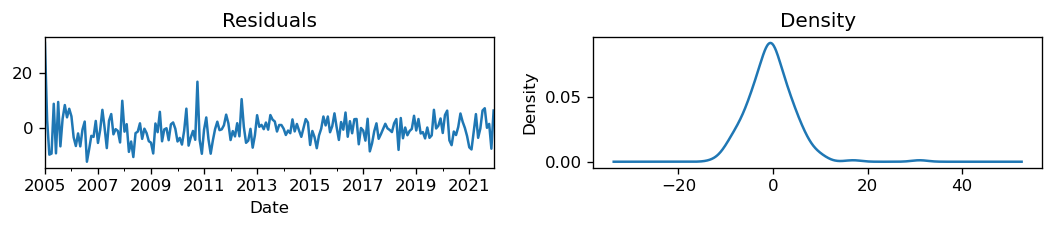

In [241]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
ax[0].legend().remove()
ax[1].legend().remove()
plt.tight_layout() 
plt.show()

**Note**

The residual errors seem fine with near zero mean and uniform variance. Let’s plot the actuals against the fitted values using **plot_predict()**.

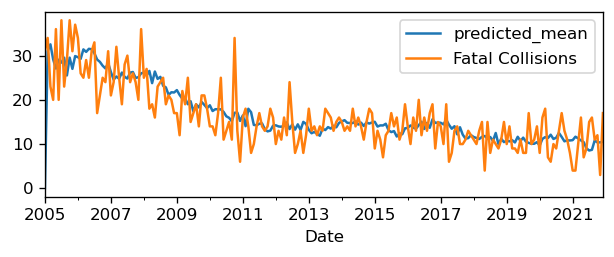

In [264]:
model_fit.predict(dynamic=False).plot()
df['Fatal Collisions'].plot(figsize=(6, 2))
plt.legend(loc='best')
plt.show()

**Note** 
- When we set dynamic=False the in-sample lagged values are used for prediction. That's how the model gets trained up until the previous value to make the next prediction. This can make the fitted forecast and actuals look artificially good.

- So, we seem to have a decent ARIMA model. But, we can’t say that this is the best ARIMA model because we haven’t actually forecasted into the future and compared the forecast with the actual performance.

- So, the real validation we need now is the Out-of-Time cross-validation.


###  Finding the optimal ARIMA model using Out-of-Time Cross validation



- In Out-of-Time cross-validation, we move backwards in time and forecast into the future to as many steps we took back. Then we compare the forecast against the actuals. 

- To do so, we will create the training and testing dataset by splitting the time series into 2 contiguous parts in a reasonable proportion based on time frequency of series.

- Now, we will build the ARIMA model on training dataset, forecast and plot it.

In [278]:
# Forecast the first AR(1) model
model = ARIMA(train, order=(4,1,1))
results  = model.fit()
PredictionResults = results.get_forecast(steps=49)
mean = PredictionResults.predicted_mean
conf = PredictionResults.conf_int(alpha=0.05)
print(results.summary())
upper = conf.iloc[:, 1]
lower = conf.iloc[:, 0]


                               SARIMAX Results                                
Dep. Variable:       Fatal Collisions   No. Observations:                  155
Model:                 ARIMA(4, 1, 1)   Log Likelihood                -453.618
Date:                Mon, 01 Jan 2024   AIC                            919.237
Time:                        22:14:59   BIC                            937.458
Sample:                    01-01-2005   HQIC                           926.638
                         - 11-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3364      0.125     -2.697      0.007      -0.581      -0.092
ar.L2         -0.3338      0.107     -3.112      0.002      -0.544      -0.124
ar.L3         -0.2307      0.105     -2.195      0.0

C:\Users\dmitri.iolchin\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\dmitri.iolchin\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\dmitri.iolchin\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


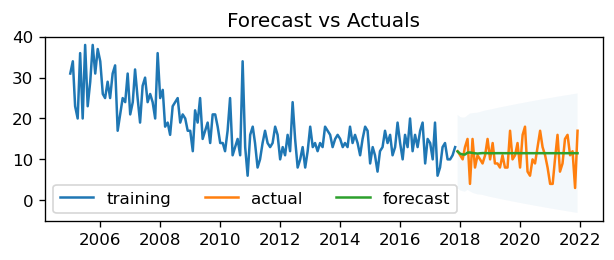

In [274]:
# Plotdd
plt.figure(figsize=(6,2))
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(mean, label='forecast')
plt.fill_between(lower.index, lower, upper, alpha=0.05)                 
plt.title('Forecast vs Actuals')
plt.legend(loc='best', ncols=3)
plt.show()

- From the above chart, the ARIMA(4,1,1) model seems to predict a correct forecast. The actual observed values lie within the 95% confidence band. 
- The P values of the AR and MA terms in the model summary is less than 0.05.


###  Accuracy Analysis for Time Series Forecast 

The commonly used accuracy metrics to judge forecasts are:

1. Mean Absolute Percentage Error (MAPE)
2. Mean Error (ME)
3. Mean Absolute Error (MAE)
4. Mean Percentage Error (MPE)
5. Root Mean Squared Error (RMSE)
6. Lag 1 Autocorrelation of Error (ACF1)
7. Correlation between the Actual and the Forecast (corr)
8. Min-Max Error (minmax)


Typically, we will use three accuracy metrices. They are percentage errors that vary between 0 and 1. That way, we can judge how good is the forecast irrespective of the scale of the series.

1. MAPE
2. Correlation and 
3. Min-Max Error 

In [275]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    min_max = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(mean-actual)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'min_max':min_max})

forecast_accuracy(mean.values, test['Fatal Collisions'].values)

{'mape': 0.4039663908699832,
 'me': 0.6330412168826595,
 'mae': 3.103023966547951,
 'mpe': 0.2464409140803596,
 'rmse': 3.768948337287347,
 'acf1': -0.04760209115228741,
 'corr': -0.019801613278383985,
 'min_max': 0.24090661834301996}

Around 15.7% MAPE implies the model is about 84.3% accurate in predicting the next 15 observations.

Now, let's automate the best model selection process. 